5th part. Extensions - Loss Functions

In [ ]:
import warnings
import os
import time
import random

from PIL import Image
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torch.utils.checkpoint import checkpoint
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torch.amp import autocast, GradScaler


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Download Data

In [ ]:
# cityscapes_id = "1OlElYRhKovWEc8gu32E8at-xNfEQniGq" # cityscapes.zip
# gta5_id = "18HzmiU3yDDvC2-BgNFVHuay5-H_8xUSV" # gta5.zip

In [ ]:
# !pip install gdown
# !gdown --id {cityscapes_id} -O "Cityscapes.zip"
# !gdown --id {gta5_id} -O "GTA5.zip"

In [ ]:
!unzip -q "/content/drive/MyDrive/semantic segmentation/Cityscapes.zip" -d "/content"
!unzip -q "/content/drive/MyDrive/semantic segmentation/GTA5.zip" -d "/content"

#Cityscapes

In [ ]:
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', image_transform=None, label_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and labels.
            split (string): One of 'train', 'val', or 'test'. Determine the sub-folder.
            image_transform (callable, optional): Transform to be applied on images.
            label_transform (callable, optional): Transform to be applied on labels.
        """
        self.root_dir = root_dir
        self.split = split
        self.image_transform = image_transform
        self.label_transform = label_transform

        self.images_dir = os.path.join(root_dir, 'images', split)
        self.labels_dir = os.path.join(root_dir, 'gtFine', split)

        self.image_paths = sorted(glob.glob(os.path.join(self.images_dir, '**', '*_leftImg8bit.png'), recursive=True))
        self.label_paths = sorted(glob.glob(os.path.join(self.labels_dir, '**', '*_gtFine_labelTrainIds.png'), recursive=True))

        assert len(self.image_paths) == len(self.label_paths), 'Number of images and labels should be equal'

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path)

        image = transforms.Resize((512, 1024))(image)
        label = transforms.Resize((512, 1024), interpolation=Image.NEAREST)(label)
        label = torch.as_tensor(np.array(label), dtype=torch.long)

        image = self.image_transform(image)
        # label = self.label_transform(label)

        return image, label

#GTA5 Dataset

In [ ]:
GTA5_to_Cityscapes = {
    7: 0,    # Road
    8: 1,    # Sidewalk
    11: 2,   # Building
    12: 3,   # Wall
    13: 4,   # Fence
    17: 5,   # Pole
    19: 6,   # Traffic light
    20: 7,   # Traffic sign
    21: 8,   # Vegetation
    22: 9,   # Terrain
    23: 10,  # Sky
    24: 11,  # Person
    25: 12,  # Rider
    26: 13,  # Car
    27: 14,  # Truck
    28: 15,  # Bus
    31: 16,  # Train
    32: 17,  # Motorcycle
    33: 18,  # Bicycle
}


def remap_gta5_labels(label_mask, mapping_dict, ignore_label=255):
    """
    Remaps GTA5 labels to Cityscapes 19-class format.

    Args:
        label_mask (np.ndarray): 2D array of GTA5 label IDs.
        mapping_dict (dict): Mapping from GTA5 label ID to Cityscapes index.
        ignore_label (int): Label to assign to unmapped pixels.

    Returns:
        np.ndarray: Remapped label mask with Cityscapes indices.
    """
    remapped = np.full_like(label_mask, fill_value=ignore_label)

    for gta_label, cityscapes_label in mapping_dict.items():
        remapped[label_mask == gta_label] = cityscapes_label

    return remapped



class GTA5Dataset(Dataset):
    def __init__(self, root_dir, image_transform=None, label_transform=None):

        self.root_dir = root_dir
        self.image_transform = image_transform
        self.label_transform = label_transform

        self.images_dir = os.path.join(root_dir, 'images')
        self.labels_dir = os.path.join(root_dir, 'labels')

        self.image_paths = sorted(glob.glob(os.path.join(self.images_dir, '*.png')))
        self.label_paths = sorted(glob.glob(os.path.join(self.labels_dir, '*.png')))

        assert len(self.image_paths) == len(self.label_paths), "Mismatch between image and label counts"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path)

        image = transforms.Resize((720, 1280))(image)
        label = transforms.Resize((720, 1280), interpolation=Image.NEAREST)(label)

        # Convert label to numpy and remap
        label_np = np.array(label, dtype=np.uint8)
        label_remapped = remap_gta5_labels(label_np, GTA5_to_Cityscapes)

        transformed = self.image_transform(image=np.array(image), mask=label_remapped)
        image = transformed['image']
        label = transformed['mask'].long()

        return image, label


Data augmentation (best one)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# prepare data

batch_size = 8 #16
data_dir_train = '/content/GTA5'
data_dir_val = '/content/Cityscapes/Cityspaces'

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# augmentation
image_aug_transforms = A.Compose([
    A.RandomScale(scale_limit=(0.0, 0.5), p=0.5),
    A.PadIfNeeded(min_height=720, min_width=1280,
                  border_mode=cv2.BORDER_CONSTANT,
                  value=0,
                  mask_value=255),
    A.RandomCrop(height=720, width=1280, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(5, 5), p=0.5),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
#train

train_dataset_1 = GTA5Dataset(
    root_dir=data_dir_train,
    image_transform=image_aug_transforms,
    label_transform=None
)

train_dataset_2 = GTA5Dataset(
    root_dir=data_dir_train,
    image_transform=image_aug_transforms,
    label_transform=None
)

#val

val_dataset = CityscapesDataset(
    root_dir=data_dir_val,
    split="val",
    image_transform=image_transforms,
    label_transform=None
)


train_dataloader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


train_dataloader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

<ipython-input-9-1670718416>:17: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=720, min_width=1280,


#Bisenet model

In [ ]:
import torch
from torch import nn
import warnings
warnings.filterwarnings(action='ignore')

import torch
from torchvision import models
from itertools import chain


class resnet18(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet18(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


class resnet101(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet101(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


def build_contextpath(name):
    model = {
        'resnet18': resnet18(pretrained=True),
        'resnet101': resnet101(pretrained=True)
    }
    return model[name]


class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        return self.relu(self.bn(x))


class Spatial_path(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels=3, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, input):
        x = self.convblock1(input)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x


class AttentionRefinementModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input):
        # global average pooling
        x = self.avgpool(input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        x = self.sigmoid(self.bn(x))
        # x = self.sigmoid(x)
        # channels of input and x should be same
        x = torch.mul(input, x)
        return x


class FeatureFusionModule(torch.nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        # self.in_channels = input_1.channels + input_2.channels
        # resnet101 3328 = 256(from spatial path) + 1024(from context path) + 2048(from context path)
        # resnet18  1024 = 256(from spatial path) + 256(from context path) + 512(from context path)
        self.in_channels = in_channels

        self.convblock = ConvBlock(in_channels=self.in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input_1, input_2):
        x = torch.cat((input_1, input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.convblock(x)
        x = self.avgpool(feature)

        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = torch.mul(feature, x)
        x = torch.add(x, feature)
        return x


class BiSeNet(torch.nn.Module):
    def __init__(self, num_classes, context_path):
        super().__init__()
        # build spatial path
        self.saptial_path = Spatial_path()

        # build context path
        self.context_path = build_contextpath(name=context_path)

        # build attention refinement module  for resnet 101
        if context_path == 'resnet101':
            self.attention_refinement_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_refinement_module2 = AttentionRefinementModule(2048, 2048)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=2048, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 3328)

        elif context_path == 'resnet18':
            # build attention refinement module  for resnet 18
            self.attention_refinement_module1 = AttentionRefinementModule(256, 256)
            self.attention_refinement_module2 = AttentionRefinementModule(512, 512)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 1024)
        else:
            print('Error: unspport context_path network \n')

        # build final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

        self.init_weight()

        self.mul_lr = []
        self.mul_lr.append(self.saptial_path)
        self.mul_lr.append(self.attention_refinement_module1)
        self.mul_lr.append(self.attention_refinement_module2)
        self.mul_lr.append(self.supervision1)
        self.mul_lr.append(self.supervision2)
        self.mul_lr.append(self.feature_fusion_module)
        self.mul_lr.append(self.conv)

    def init_weight(self):
        for name, m in self.named_modules():
            if 'context_path' not in name:
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d):
                    m.eps = 1e-5
                    m.momentum = 0.1
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # output of spatial path
        sx = self.saptial_path(input)

        # output of context path
        cx1, cx2, tail = self.context_path(input)
        cx1 = self.attention_refinement_module1(cx1)
        cx2 = self.attention_refinement_module2(cx2)
        cx2 = torch.mul(cx2, tail)
        # upsampling
        cx1 = torch.nn.functional.interpolate(cx1, size=sx.size()[-2:], mode='bilinear')
        cx2 = torch.nn.functional.interpolate(cx2, size=sx.size()[-2:], mode='bilinear')
        cx = torch.cat((cx1, cx2), dim=1)

        if self.training == True:
            cx1_sup = self.supervision1(cx1)
            cx2_sup = self.supervision2(cx2)
            cx1_sup = torch.nn.functional.interpolate(cx1_sup, size=input.size()[-2:], mode='bilinear')
            cx2_sup = torch.nn.functional.interpolate(cx2_sup, size=input.size()[-2:], mode='bilinear')

        # output of feature fusion module
        result = self.feature_fusion_module(sx, cx)

        # upsampling
        result = torch.nn.functional.interpolate(result, scale_factor=8, mode='bilinear')
        result = self.conv(result)

        if self.training == True:
            return result, cx1_sup, cx2_sup

        return result

    def optim_parameters(self, lr): # new
      return [
          {'params': self.context_path.parameters(), 'lr': lr},               # 1x
          {'params': chain(*(m.parameters() for m in self.mul_lr)), 'lr': lr * 10}  # 10x
      ]

In [ ]:
def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1,
                      max_iter=300, power=0.9):
    """Polynomial decay of learning rate
            :param init_lr is base learning rate
            :param iter is a current iteration
            :param lr_decay_iter how frequently decay occurs, default is 1
            :param max_iter is number of maximum iterations
            :param power is a polymomial power

    """

    lr = init_lr*(1 - iter/max_iter)**power
    optimizer.param_groups[0]['lr'] = lr
    optimizer.param_groups[1]['lr'] = lr * 10 # new
    return lr


def fast_hist(a, b, n):
    '''
    a and b are label and prediction respectively
    n is the number of classes
    '''
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)


def per_class_iou(hist):
    epsilon = 1e-5
    return (np.diag(hist)) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

In [ ]:
CITYSCAPES_CLASSES = [
    'Road', 'Sidewalk', 'Building', 'Wall', 'Fence', 'Pole', 'Traffic light',
    'Traffic sign', 'Vegetation', 'Terrain', 'Sky', 'Person', 'Rider', 'Car',
    'Truck', 'Bus', 'Train', 'Motorcycle', 'Bicycle'
]

#Training

In [ ]:
train_dataloader = train_dataloader_1
log_csv_path = '/content/drive/MyDrive/semantic segmentation/bisenet+loss_functions/dice+focal/bisenet_train_log.csv'
checkpoint_path = "/content/drive/MyDrive/semantic segmentation/bisenet+loss_functions/dice+focal/checkpoint.pth"
lossmiou = '/content/drive/MyDrive/semantic segmentation/bisenet+loss_functions/dice+focal/bisenet_loss_miou_plot.png'

#Dice + Focal


For class distributions and disbalance

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Dice for Source data

class DiceLoss(nn.Module):

    def __init__(self, smooth=1e-6, ignore_index=255):
        super(DiceLoss, self).__init__()
        # Smoothing factor to avoid division by zero
        self.smooth = smooth
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        # Apply softmax to predicted logits along the class dimension
        inputs = F.softmax(inputs, dim=1)

        # Create a binary mask to ignore specified pixels
        valid_mask = (targets != self.ignore_index)
        targets_masked = targets * valid_mask

       # Convert target labels to one-hot encoding
        num_classes = inputs.size(1)
        targets_one_hot = F.one_hot(targets_masked, num_classes=num_classes).permute(0, 3, 1, 2).float()

        # Apply the mask to inputs and targets
        inputs_masked = inputs * valid_mask.unsqueeze(1)
        targets_one_hot_masked = targets_one_hot * valid_mask.unsqueeze(1)

        # Compute intersection and union for Dice calculation
        intersection = (inputs_masked * targets_one_hot_masked).sum(dim=(2, 3))
        union = inputs_masked.sum(dim=(2, 3)) + targets_one_hot_masked.sum(dim=(2, 3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice.mean()

        return dice_loss

class FocalLoss(nn.Module):
    """Focal Loss to address class imbalance in segmentation"""
    def __init__(self, alpha=1.0, gamma=2.0, ignore_index=255):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        # Compute standard CrossEntropy loss without reduction
        ce_loss = F.cross_entropy(inputs, targets, ignore_index=self.ignore_index, reduction='none')

        # Compute model confidence (probability of correct class)
        pt = torch.exp(-ce_loss)

        # Compute the focal weight
        focal_weight = (1 - pt) ** self.gamma

        # Apply the alpha and focal weight to the loss
        focal_loss = self.alpha * focal_weight * ce_loss

        return focal_loss.mean()

class CombinedLoss(nn.Module):
    """Combined loss: weighted sum of DiceLoss and FocalLoss"""
    def __init__(self, dice_weight=0.5, focal_weight=0.5,
                 focal_alpha=1.0, focal_gamma=2.0, ignore_index=255):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight

        # Initialize loss components
        self.dice_loss = DiceLoss(ignore_index=ignore_index)
        self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, ignore_index=ignore_index)

    def forward(self, inputs, targets):
        # Compute both losses
        dice = self.dice_loss(inputs, targets)
        focal = self.focal_loss(inputs, targets)

        # Weighted sum of the two losses
        combined = self.dice_weight * dice + self.focal_weight * focal
        return combined, dice, focal

Epoch 1/50
  Total Loss: 1.0051
  Dice Loss:  1.4776
  Focal Loss: 0.6901


Per-class IoU:
  Road            : 0.6555
  Sidewalk        : 0.0862
  Building        : 0.6846
  Wall            : 0.0841
  Fence           : 0.0904
  Pole            : 0.0541
  Traffic light   : 0.0000
  Traffic sign    : 0.0000
  Vegetation      : 0.6823
  Terrain         : 0.1654
  Sky             : 0.7339
  Person          : 0.0018
  Rider           : 0.0000
  Car             : 0.4750
  Truck           : 0.0422
  Bus             : 0.0480
  Train           : 0.0000
  Motorcycle      : 0.0000
  Bicycle         : 0.0000
  Mean IoU: 0.2002


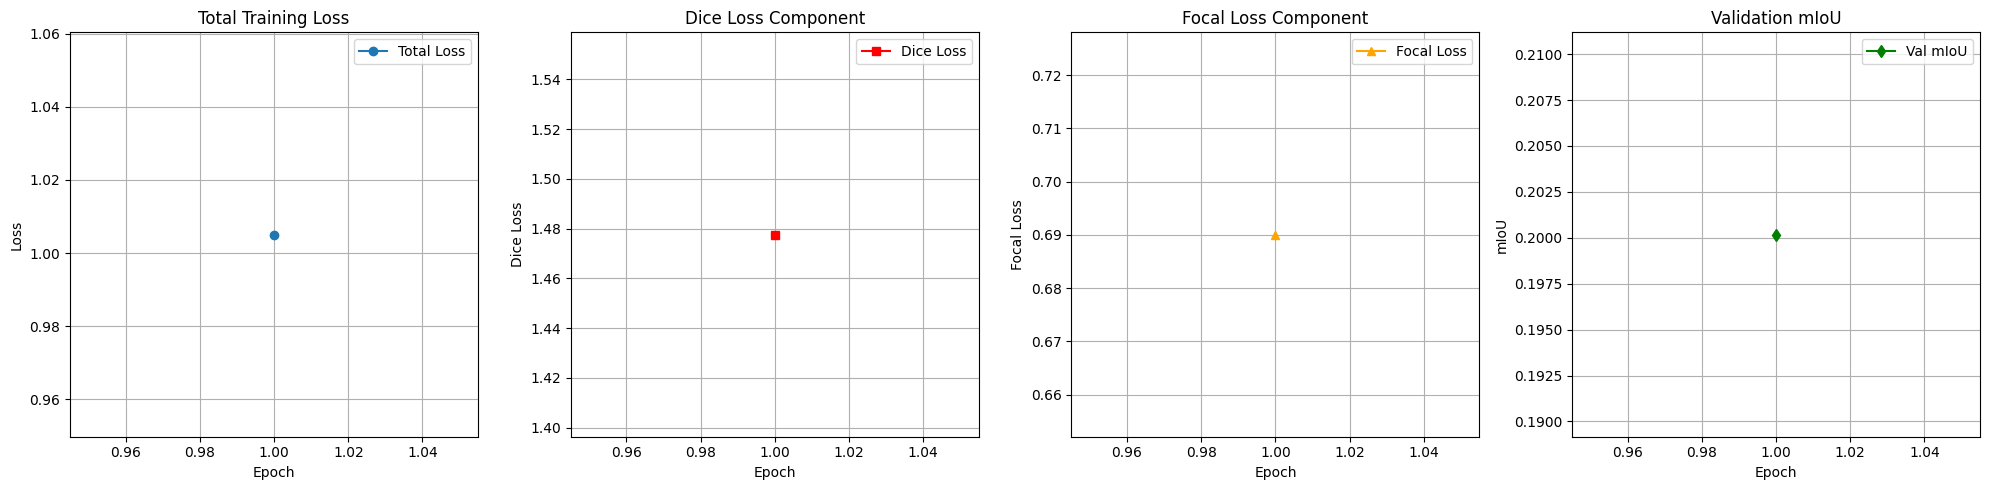

Epoch 2/50
  Total Loss: 0.7860
  Dice Loss:  1.3904
  Focal Loss: 0.3831


Per-class IoU:
  Road            : 0.2576
  Sidewalk        : 0.1497
  Building        : 0.6196
  Wall            : 0.0646
  Fence           : 0.1494
  Pole            : 0.1269
  Traffic light   : 0.0000
  Traffic sign    : 0.0751
  Vegetation      : 0.7022
  Terrain         : 0.1567
  Sky             : 0.6858
  Person          : 0.3386
  Rider           : 0.0000
  Car             : 0.2382
  Truck           : 0.0159
  Bus             : 0.0485
  Train           : 0.0360
  Motorcycle      : 0.0000
  Bicycle         : 0.0000
  Mean IoU: 0.1929


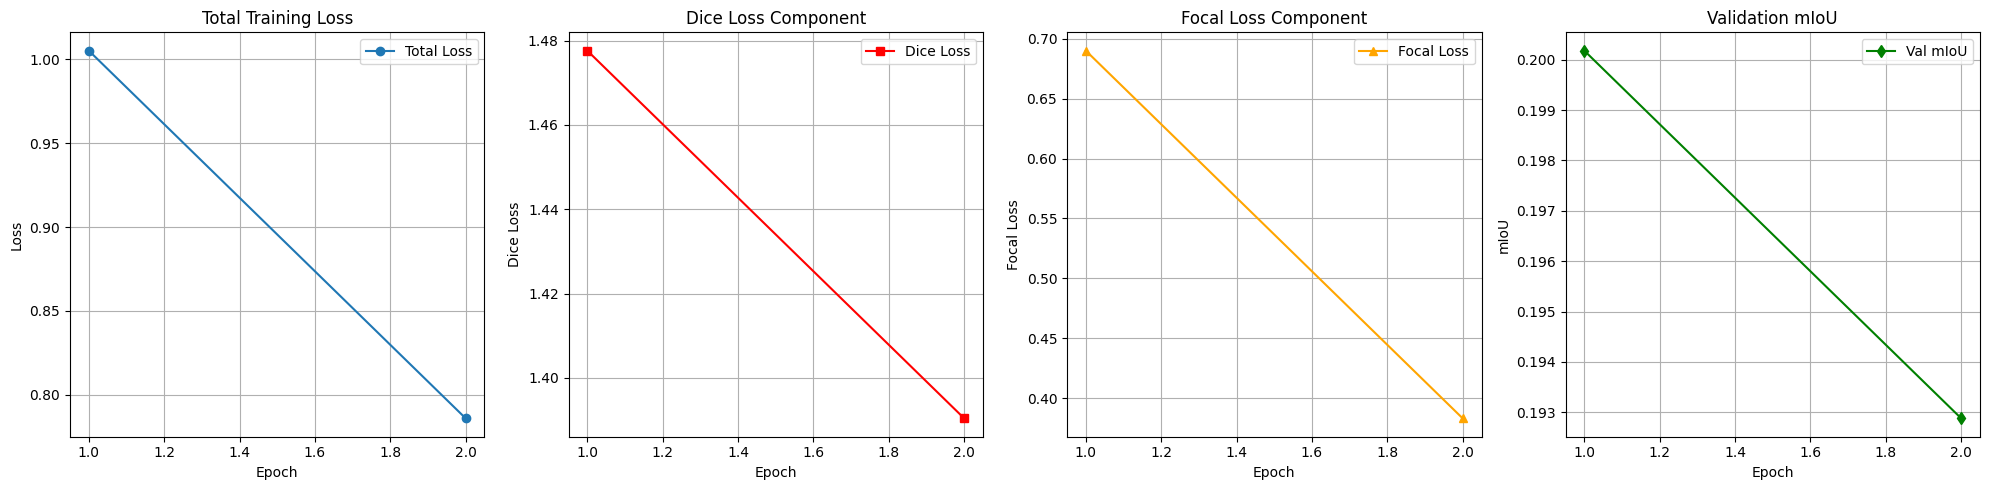

Epoch 3/50
  Total Loss: 0.7307
  Dice Loss:  1.3505
  Focal Loss: 0.3176


Per-class IoU:
  Road            : 0.6113
  Sidewalk        : 0.2601
  Building        : 0.6642
  Wall            : 0.1464
  Fence           : 0.1620
  Pole            : 0.1544
  Traffic light   : 0.0925
  Traffic sign    : 0.1382
  Vegetation      : 0.7392
  Terrain         : 0.2864
  Sky             : 0.7094
  Person          : 0.2994
  Rider           : 0.0430
  Car             : 0.3739
  Truck           : 0.0731
  Bus             : 0.1789
  Train           : 0.0000
  Motorcycle      : 0.0044
  Bicycle         : 0.0000
  Mean IoU: 0.2598


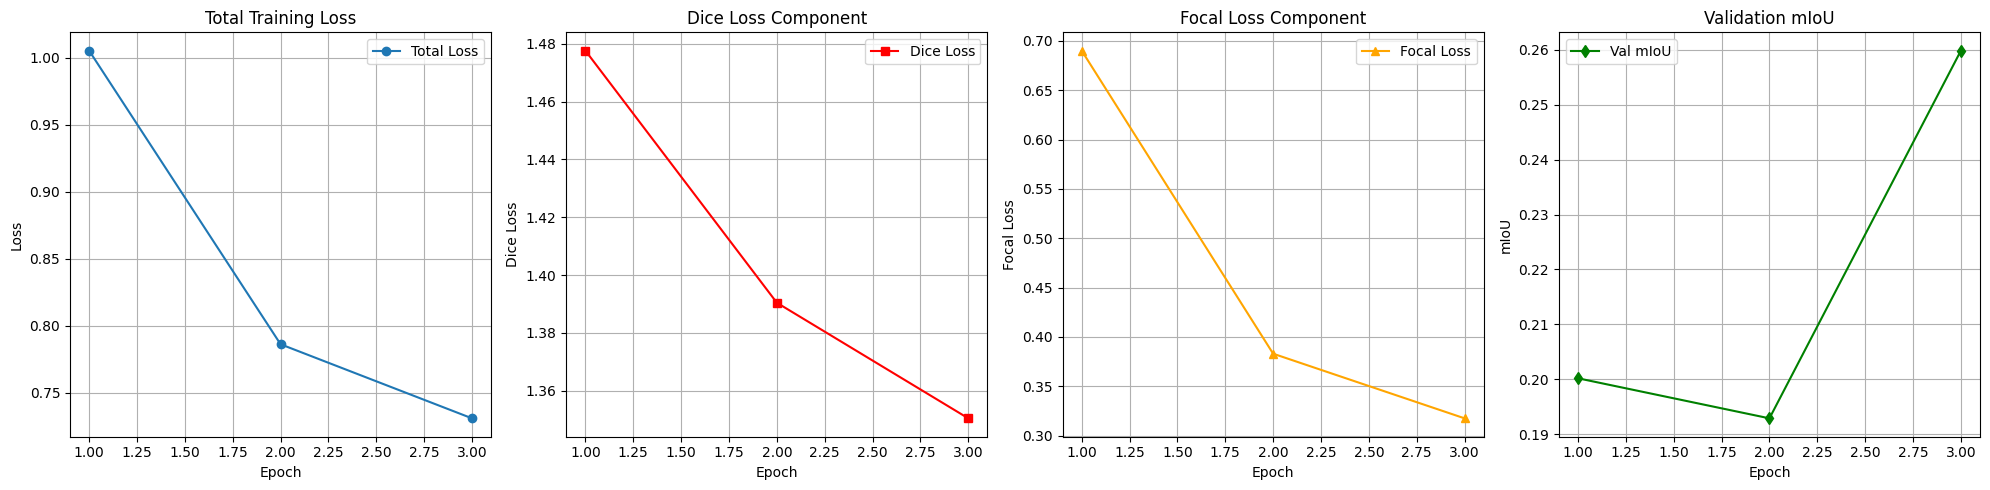

Epoch 4/50
  Total Loss: 0.6997
  Dice Loss:  1.3209
  Focal Loss: 0.2856


Per-class IoU:
  Road            : 0.3889
  Sidewalk        : 0.0624
  Building        : 0.6088
  Wall            : 0.0937
  Fence           : 0.1472
  Pole            : 0.1091
  Traffic light   : 0.1327
  Traffic sign    : 0.1319
  Vegetation      : 0.7539
  Terrain         : 0.2701
  Sky             : 0.6701
  Person          : 0.3376
  Rider           : 0.0164
  Car             : 0.2481
  Truck           : 0.0807
  Bus             : 0.0996
  Train           : 0.0126
  Motorcycle      : 0.0287
  Bicycle         : 0.0000
  Mean IoU: 0.2207


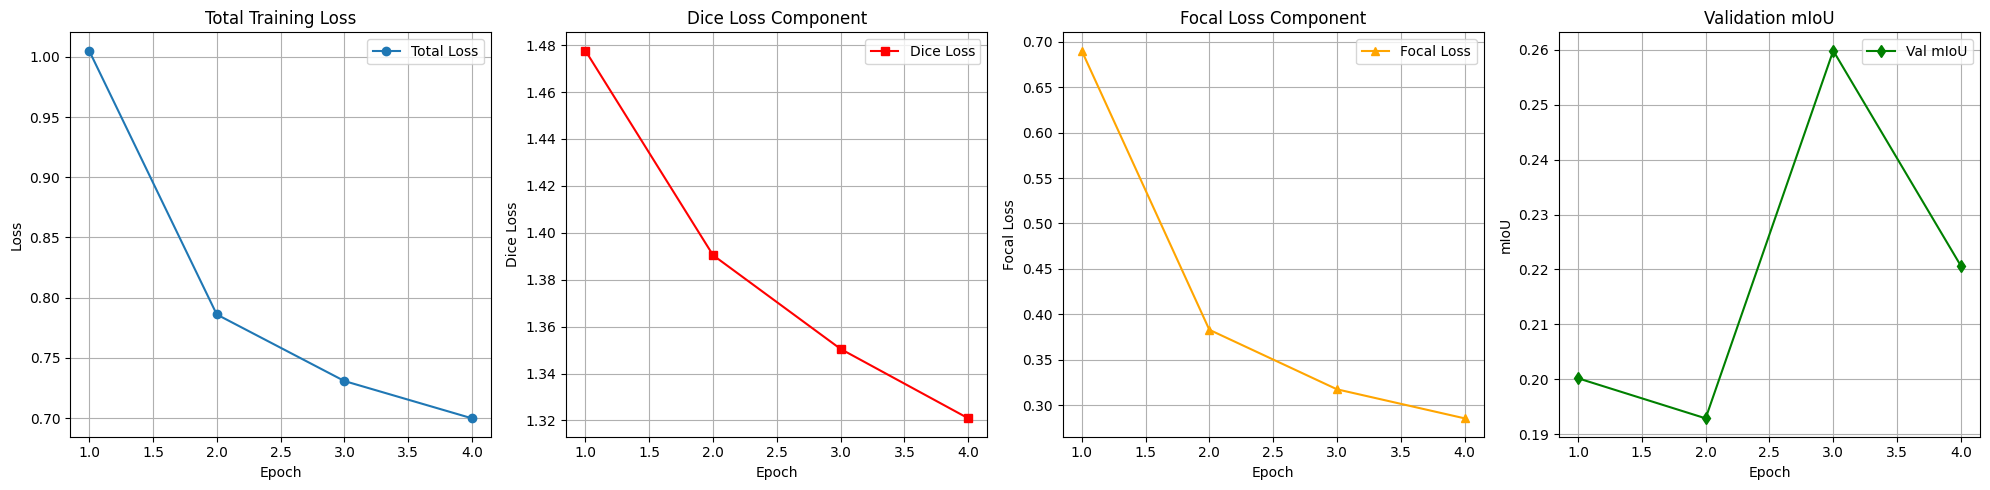

Epoch 5/50
  Total Loss: 0.6815
  Dice Loss:  1.3020
  Focal Loss: 0.2679


Per-class IoU:
  Road            : 0.4340
  Sidewalk        : 0.1249
  Building        : 0.6294
  Wall            : 0.1344
  Fence           : 0.1788
  Pole            : 0.2162
  Traffic light   : 0.0961
  Traffic sign    : 0.1962
  Vegetation      : 0.7616
  Terrain         : 0.2686
  Sky             : 0.6995
  Person          : 0.3665
  Rider           : 0.0527
  Car             : 0.3274
  Truck           : 0.0299
  Bus             : 0.1078
  Train           : 0.0239
  Motorcycle      : 0.0353
  Bicycle         : 0.0000
  Mean IoU: 0.2465
  Checkpoint saved at /content/drive/MyDrive/semantic segmentation/bisenet+loss_functions/dice+focal/checkpoint.pth


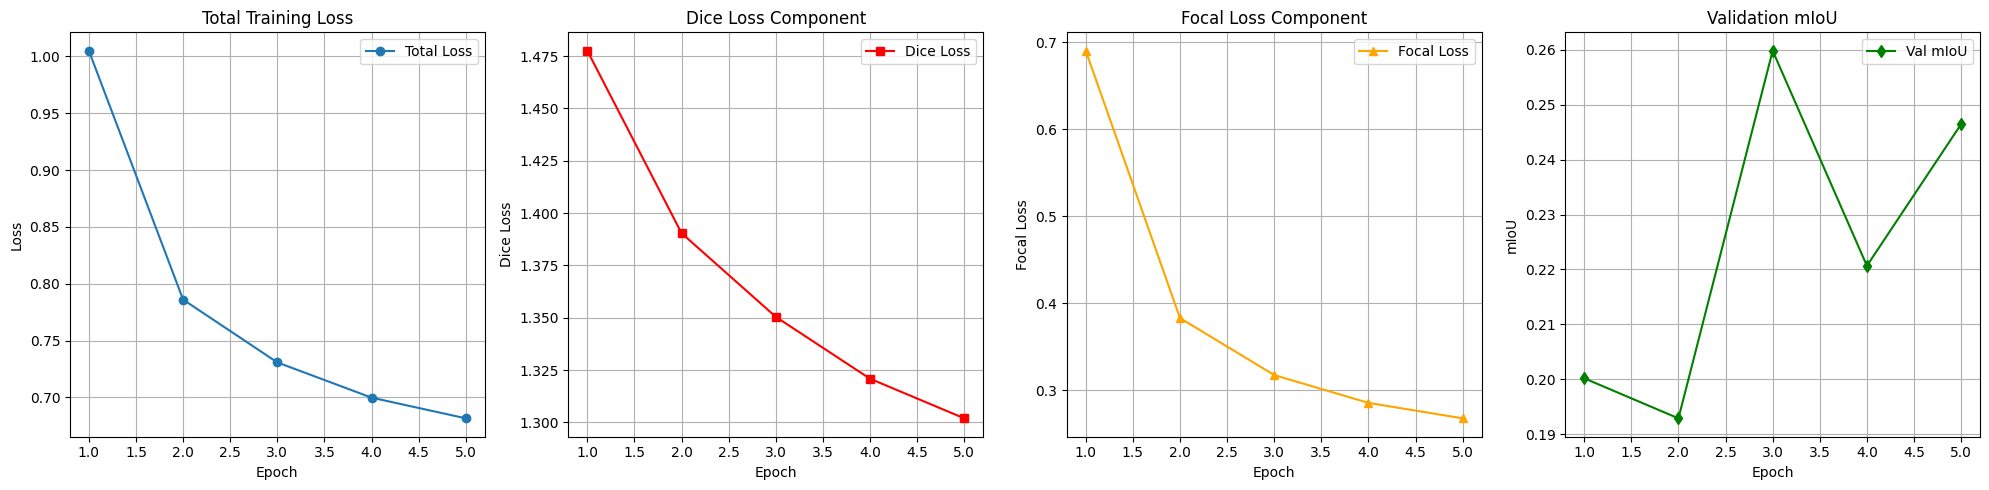

Epoch 6/50
  Total Loss: 0.6663
  Dice Loss:  1.2859
  Focal Loss: 0.2532


Per-class IoU:
  Road            : 0.5964
  Sidewalk        : 0.1542
  Building        : 0.6661
  Wall            : 0.1275
  Fence           : 0.1765
  Pole            : 0.2194
  Traffic light   : 0.1624
  Traffic sign    : 0.2170
  Vegetation      : 0.7044
  Terrain         : 0.1530
  Sky             : 0.6948
  Person          : 0.4541
  Rider           : 0.1247
  Car             : 0.4246
  Truck           : 0.0320
  Bus             : 0.0626
  Train           : 0.0521
  Motorcycle      : 0.0946
  Bicycle         : 0.0000
  Mean IoU: 0.2693


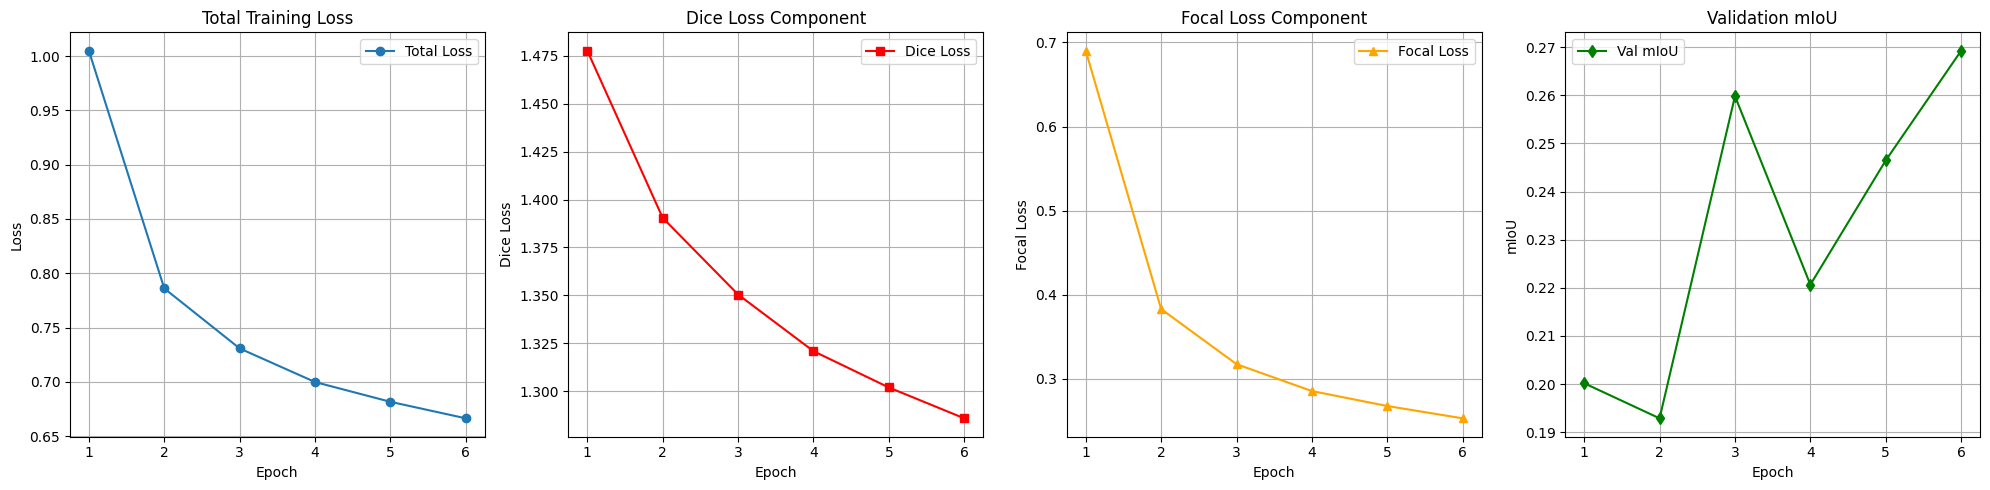

Epoch 7/50
  Total Loss: 0.6564
  Dice Loss:  1.2753
  Focal Loss: 0.2438


Per-class IoU:
  Road            : 0.4180
  Sidewalk        : 0.1942
  Building        : 0.6128
  Wall            : 0.1262
  Fence           : 0.1854
  Pole            : 0.2131
  Traffic light   : 0.1782
  Traffic sign    : 0.1755
  Vegetation      : 0.6873
  Terrain         : 0.0926
  Sky             : 0.6999
  Person          : 0.4545
  Rider           : 0.0738
  Car             : 0.2897
  Truck           : 0.0993
  Bus             : 0.0390
  Train           : 0.1379
  Motorcycle      : 0.0919
  Bicycle         : 0.0000
  Mean IoU: 0.2510


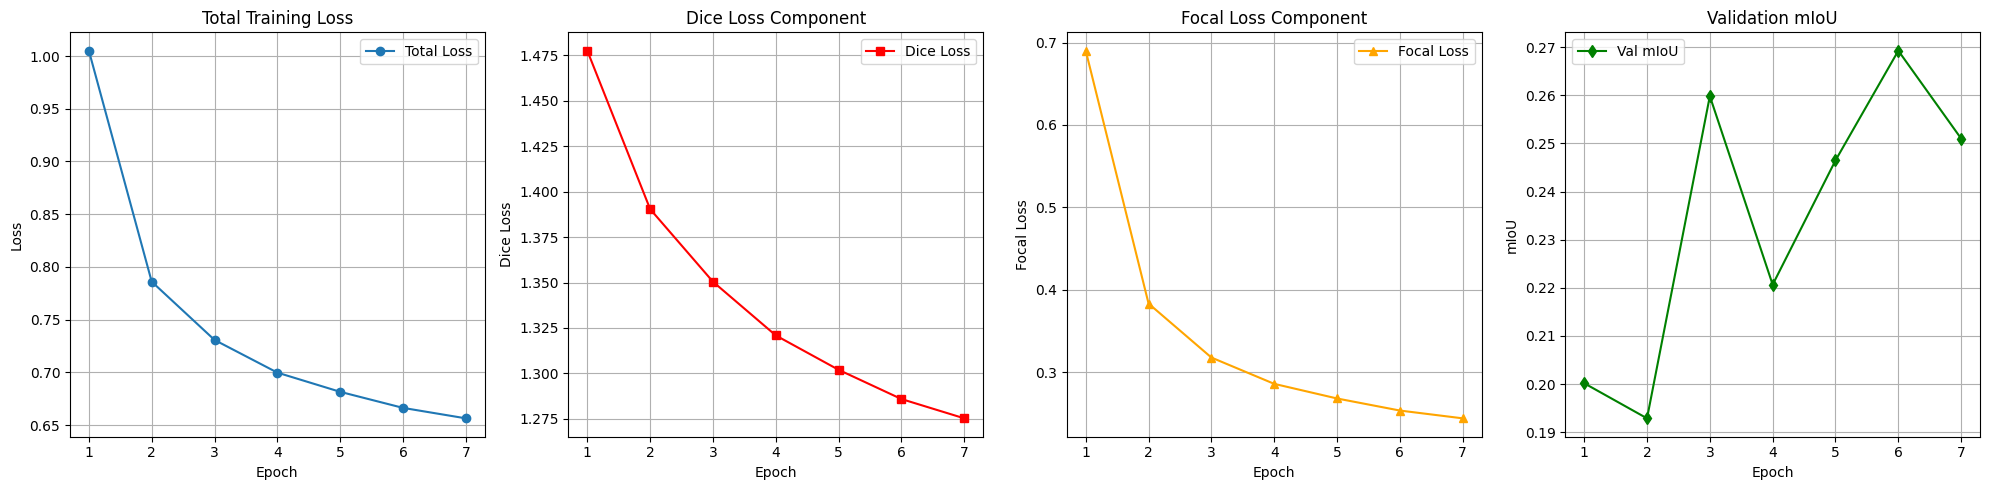

Epoch 8/50
  Total Loss: 0.6485
  Dice Loss:  1.2660
  Focal Loss: 0.2368


Per-class IoU:
  Road            : 0.5400
  Sidewalk        : 0.1411
  Building        : 0.7087
  Wall            : 0.1568
  Fence           : 0.1614
  Pole            : 0.2130
  Traffic light   : 0.1917
  Traffic sign    : 0.2124
  Vegetation      : 0.7675
  Terrain         : 0.2728
  Sky             : 0.7408
  Person          : 0.4369
  Rider           : 0.1018
  Car             : 0.2569
  Truck           : 0.1564
  Bus             : 0.1076
  Train           : 0.0267
  Motorcycle      : 0.0526
  Bicycle         : 0.0000
  Mean IoU: 0.2761


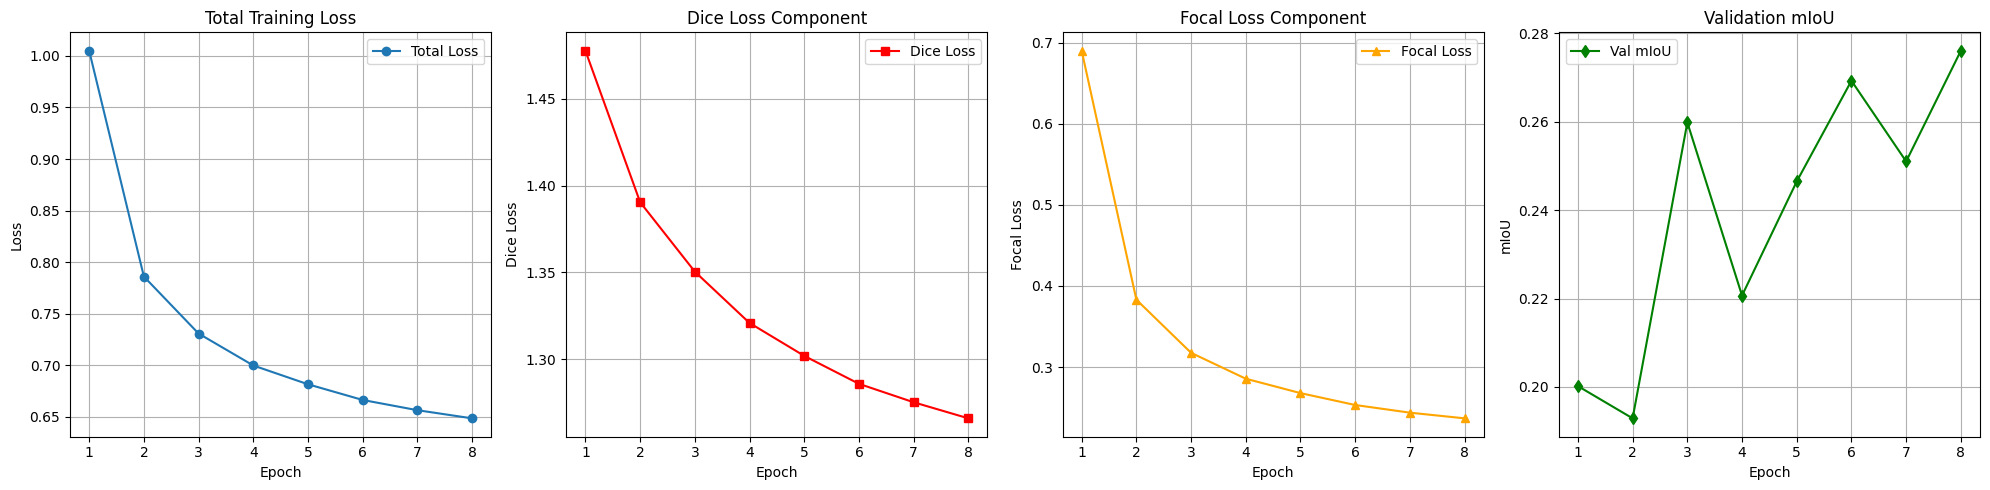

Epoch 9/50
  Total Loss: 0.6396
  Dice Loss:  1.2574
  Focal Loss: 0.2278


Per-class IoU:
  Road            : 0.5074
  Sidewalk        : 0.0809
  Building        : 0.6763
  Wall            : 0.1683
  Fence           : 0.1791
  Pole            : 0.2279
  Traffic light   : 0.1849
  Traffic sign    : 0.1912
  Vegetation      : 0.7397
  Terrain         : 0.1980
  Sky             : 0.7007
  Person          : 0.4639
  Rider           : 0.0925
  Car             : 0.2831
  Truck           : 0.0407
  Bus             : 0.0781
  Train           : 0.0393
  Motorcycle      : 0.0632
  Bicycle         : 0.0000
  Mean IoU: 0.2587


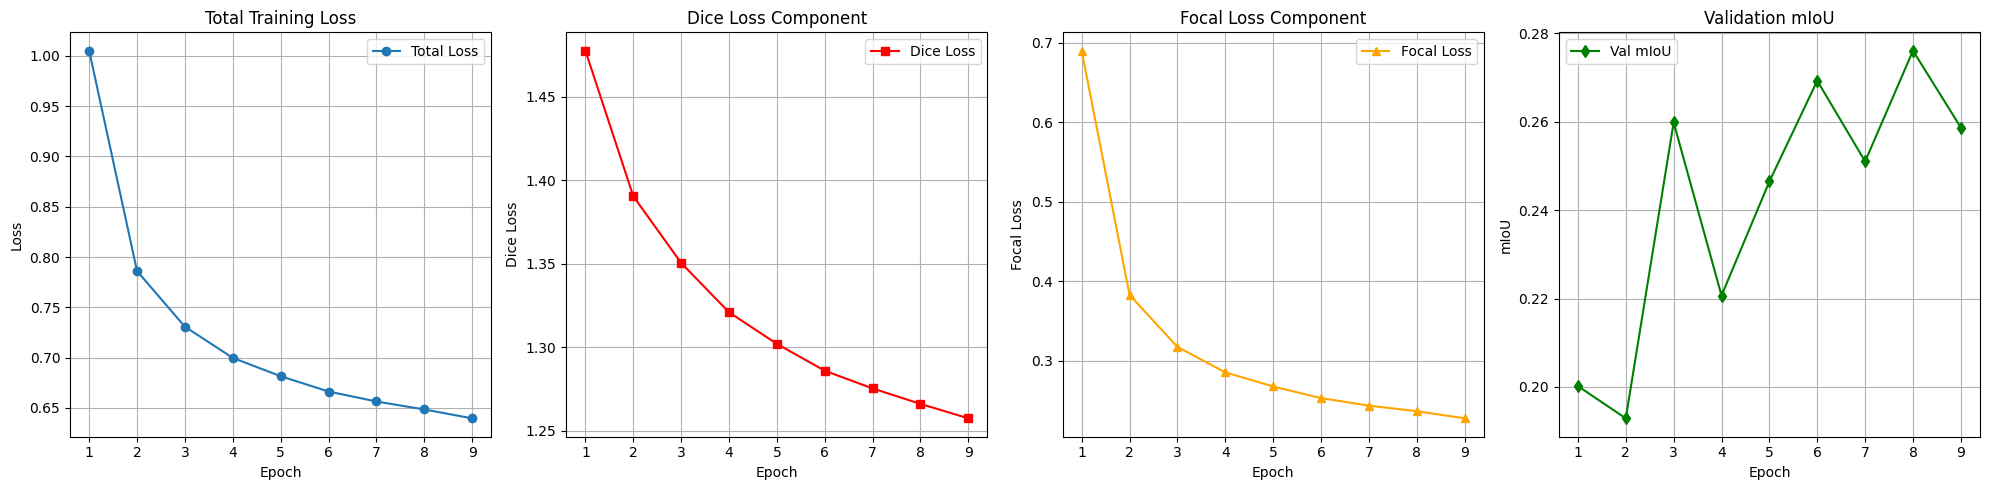

Epoch 10/50
  Total Loss: 0.6335
  Dice Loss:  1.2502
  Focal Loss: 0.2223


Per-class IoU:
  Road            : 0.3185
  Sidewalk        : 0.2997
  Building        : 0.6866
  Wall            : 0.1584
  Fence           : 0.1524
  Pole            : 0.2069
  Traffic light   : 0.1934
  Traffic sign    : 0.1740
  Vegetation      : 0.7590
  Terrain         : 0.1717
  Sky             : 0.7252
  Person          : 0.4409
  Rider           : 0.0740
  Car             : 0.2056
  Truck           : 0.1407
  Bus             : 0.0451
  Train           : 0.0446
  Motorcycle      : 0.0566
  Bicycle         : 0.0000
  Mean IoU: 0.2554
  Checkpoint saved at /content/drive/MyDrive/semantic segmentation/bisenet+loss_functions/dice+focal/checkpoint.pth


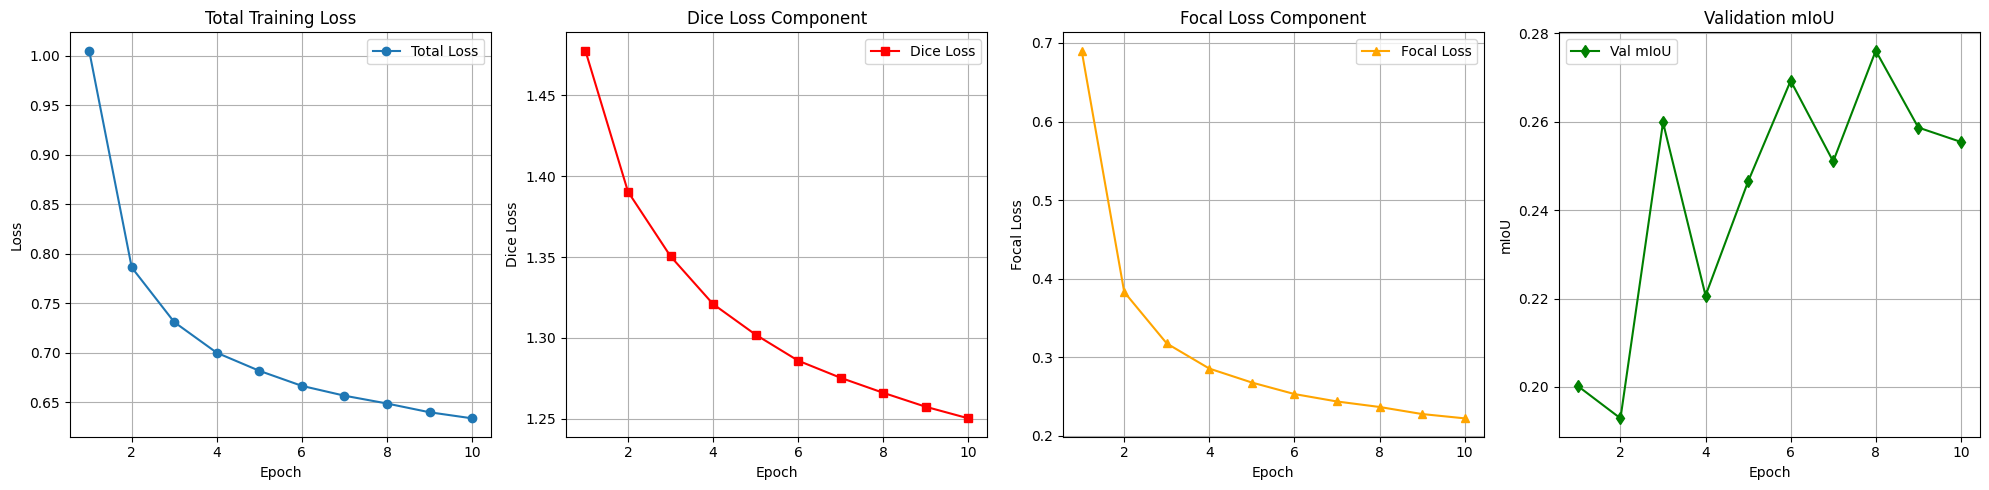

Epoch 11/50
  Total Loss: 0.6284
  Dice Loss:  1.2431
  Focal Loss: 0.2185


Per-class IoU:
  Road            : 0.5636
  Sidewalk        : 0.3121
  Building        : 0.6554
  Wall            : 0.1054
  Fence           : 0.1902
  Pole            : 0.2227
  Traffic light   : 0.1953
  Traffic sign    : 0.1110
  Vegetation      : 0.7646
  Terrain         : 0.2480
  Sky             : 0.6998
  Person          : 0.4360
  Rider           : 0.0775
  Car             : 0.3090
  Truck           : 0.0450
  Bus             : 0.1896
  Train           : 0.0563
  Motorcycle      : 0.0622
  Bicycle         : 0.0000
  Mean IoU: 0.2760


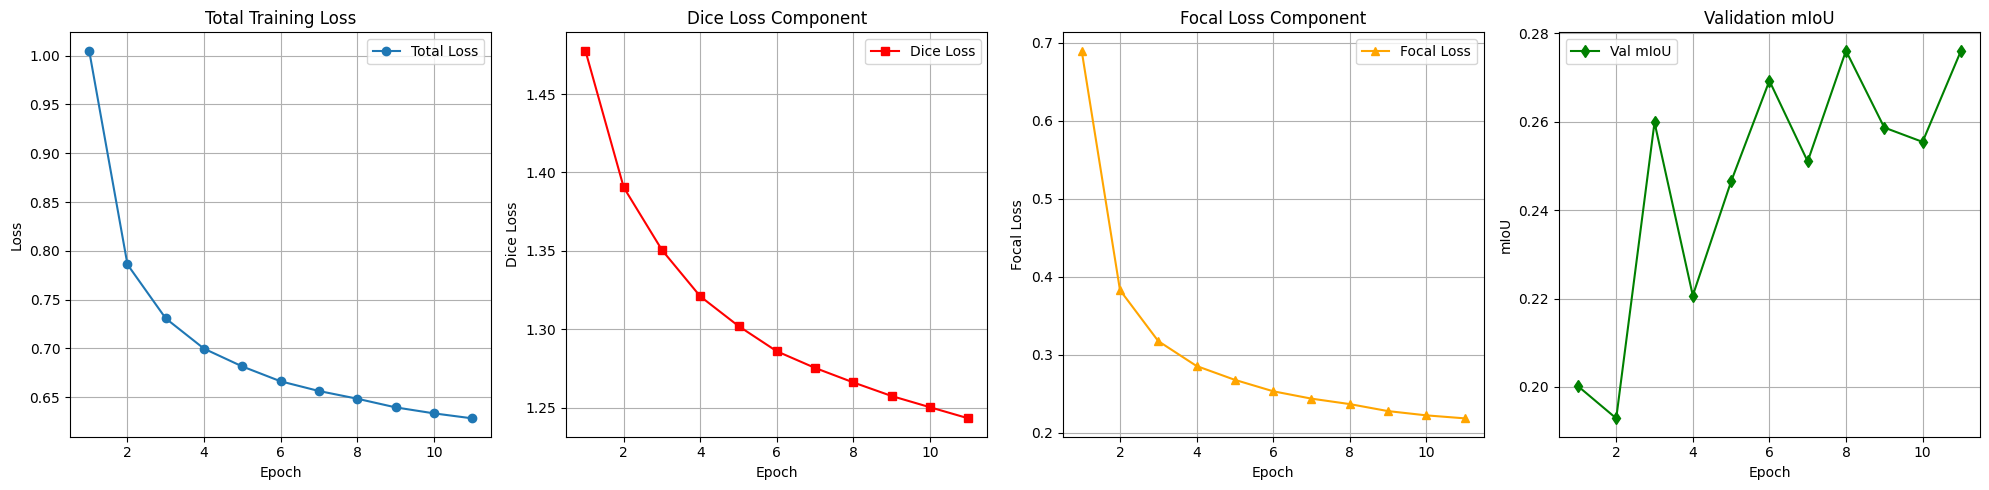

Epoch 12/50
  Total Loss: 0.6258
  Dice Loss:  1.2392
  Focal Loss: 0.2169


Per-class IoU:
  Road            : 0.5774
  Sidewalk        : 0.2284
  Building        : 0.6846
  Wall            : 0.1487
  Fence           : 0.1512
  Pole            : 0.2530
  Traffic light   : 0.2467
  Traffic sign    : 0.1915
  Vegetation      : 0.7595
  Terrain         : 0.2227
  Sky             : 0.7425
  Person          : 0.4733
  Rider           : 0.1077
  Car             : 0.3443
  Truck           : 0.0662
  Bus             : 0.1146
  Train           : 0.0607
  Motorcycle      : 0.0753
  Bicycle         : 0.0000
  Mean IoU: 0.2868


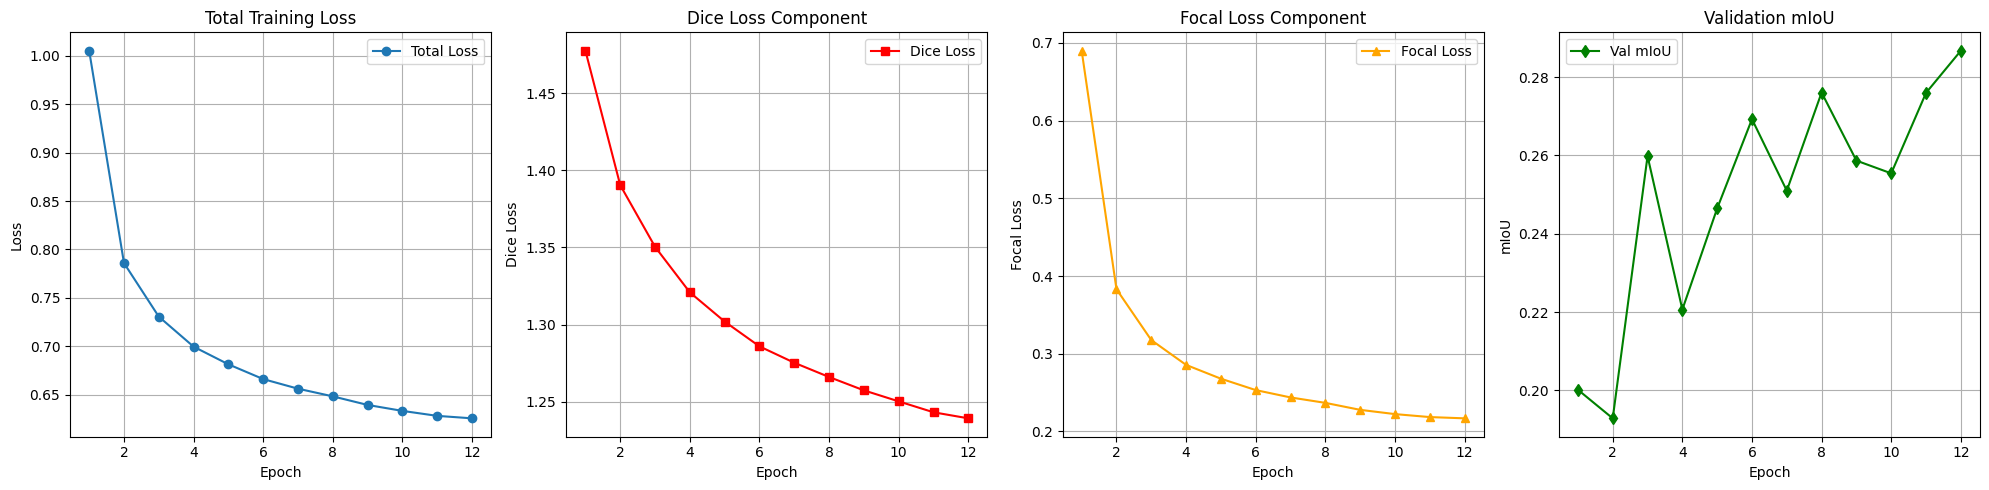

Epoch 13/50
  Total Loss: 0.6190
  Dice Loss:  1.2316
  Focal Loss: 0.2106


Per-class IoU:
  Road            : 0.4518
  Sidewalk        : 0.2881
  Building        : 0.7399
  Wall            : 0.1687
  Fence           : 0.1943
  Pole            : 0.2610
  Traffic light   : 0.1987
  Traffic sign    : 0.2119
  Vegetation      : 0.7561
  Terrain         : 0.0965
  Sky             : 0.7510
  Person          : 0.4626
  Rider           : 0.1186
  Car             : 0.2757
  Truck           : 0.0711
  Bus             : 0.1754
  Train           : 0.0254
  Motorcycle      : 0.0749
  Bicycle         : 0.0000
  Mean IoU: 0.2801


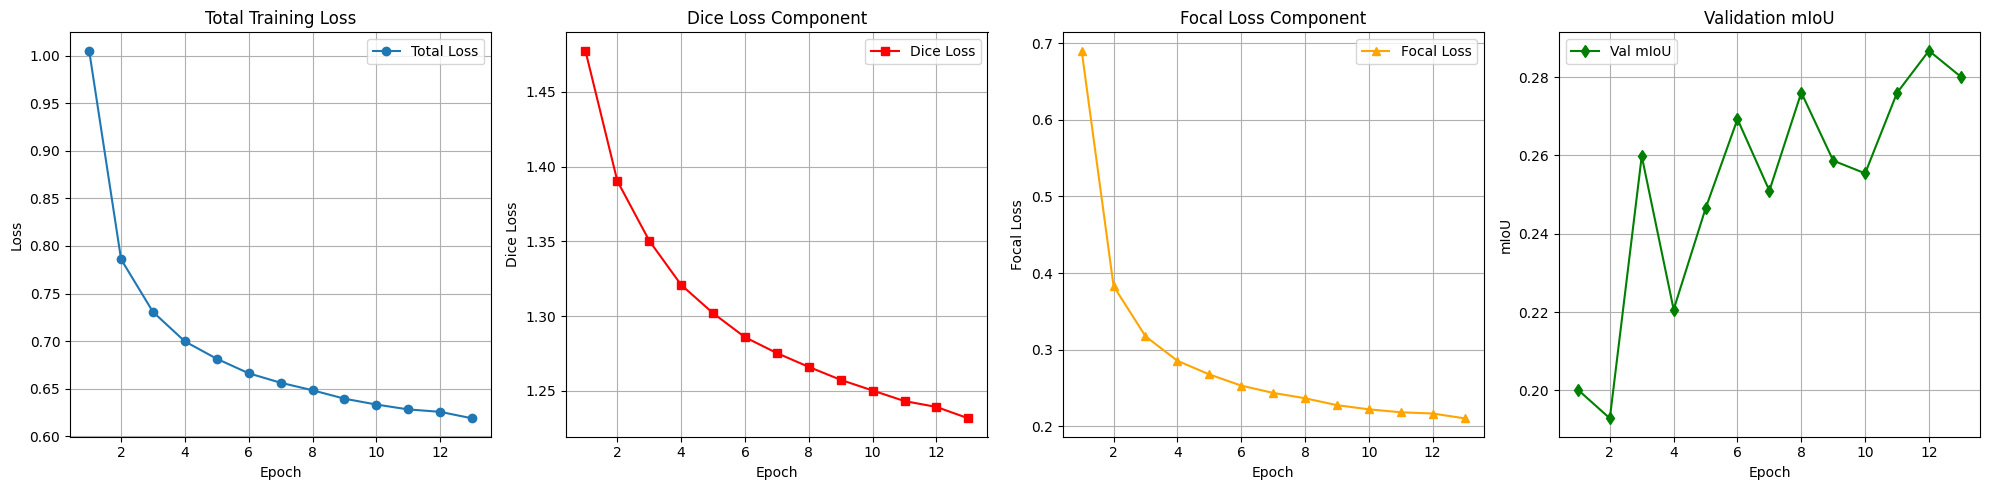

Epoch 14/50
  Total Loss: 0.6139
  Dice Loss:  1.2259
  Focal Loss: 0.2059


Per-class IoU:
  Road            : 0.4331
  Sidewalk        : 0.2450
  Building        : 0.6891
  Wall            : 0.1506
  Fence           : 0.1791
  Pole            : 0.2326
  Traffic light   : 0.2242
  Traffic sign    : 0.1491
  Vegetation      : 0.7663
  Terrain         : 0.1636
  Sky             : 0.3421
  Person          : 0.4512
  Rider           : 0.0778
  Car             : 0.2556
  Truck           : 0.0538
  Bus             : 0.1736
  Train           : 0.0275
  Motorcycle      : 0.0875
  Bicycle         : 0.0000
  Mean IoU: 0.2475


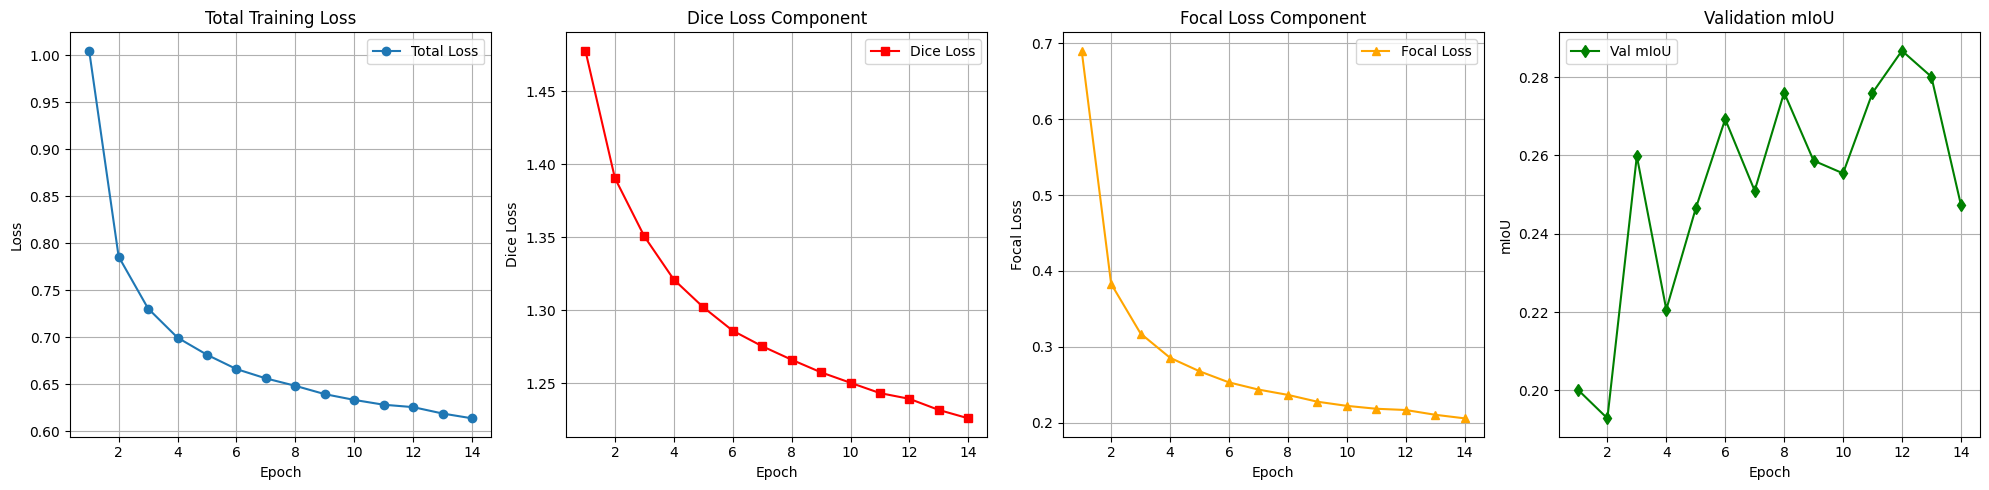

Epoch 15/50
  Total Loss: 0.6090
  Dice Loss:  1.2205
  Focal Loss: 0.2014


Per-class IoU:
  Road            : 0.5618
  Sidewalk        : 0.2486
  Building        : 0.6368
  Wall            : 0.1508
  Fence           : 0.2284
  Pole            : 0.2150
  Traffic light   : 0.1933
  Traffic sign    : 0.1668
  Vegetation      : 0.7289
  Terrain         : 0.2138
  Sky             : 0.6781
  Person          : 0.4807
  Rider           : 0.1347
  Car             : 0.3363
  Truck           : 0.0617
  Bus             : 0.1140
  Train           : 0.0594
  Motorcycle      : 0.0940
  Bicycle         : 0.0000
  Mean IoU: 0.2791
  Checkpoint saved at /content/drive/MyDrive/semantic segmentation/bisenet+loss_functions/dice+focal/checkpoint.pth


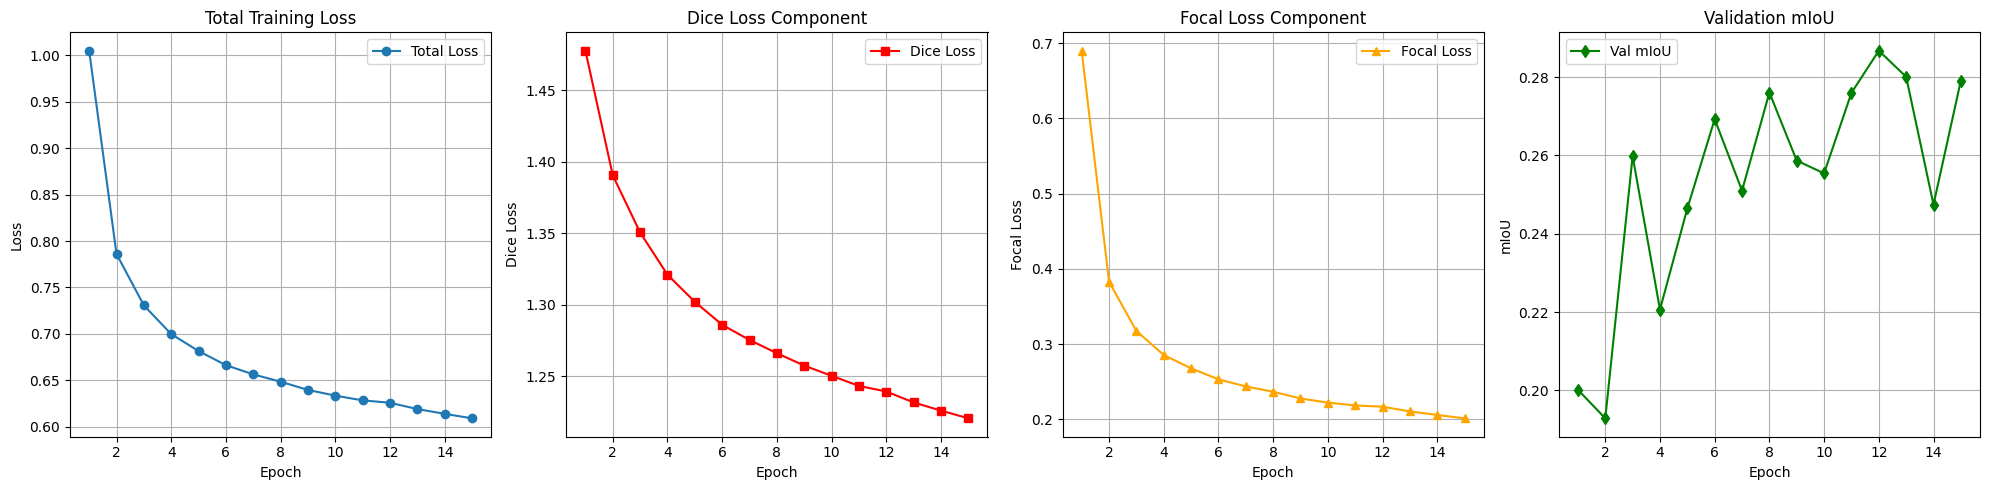

Epoch 16/50
  Total Loss: 0.6053
  Dice Loss:  1.2162
  Focal Loss: 0.1980


Per-class IoU:
  Road            : 0.4120
  Sidewalk        : 0.2524
  Building        : 0.7405
  Wall            : 0.1596
  Fence           : 0.1525
  Pole            : 0.2403
  Traffic light   : 0.2359
  Traffic sign    : 0.2056
  Vegetation      : 0.7794
  Terrain         : 0.1260
  Sky             : 0.6994
  Person          : 0.4675
  Rider           : 0.1147
  Car             : 0.2444
  Truck           : 0.1207
  Bus             : 0.1200
  Train           : 0.0416
  Motorcycle      : 0.0710
  Bicycle         : 0.0000
  Mean IoU: 0.2728


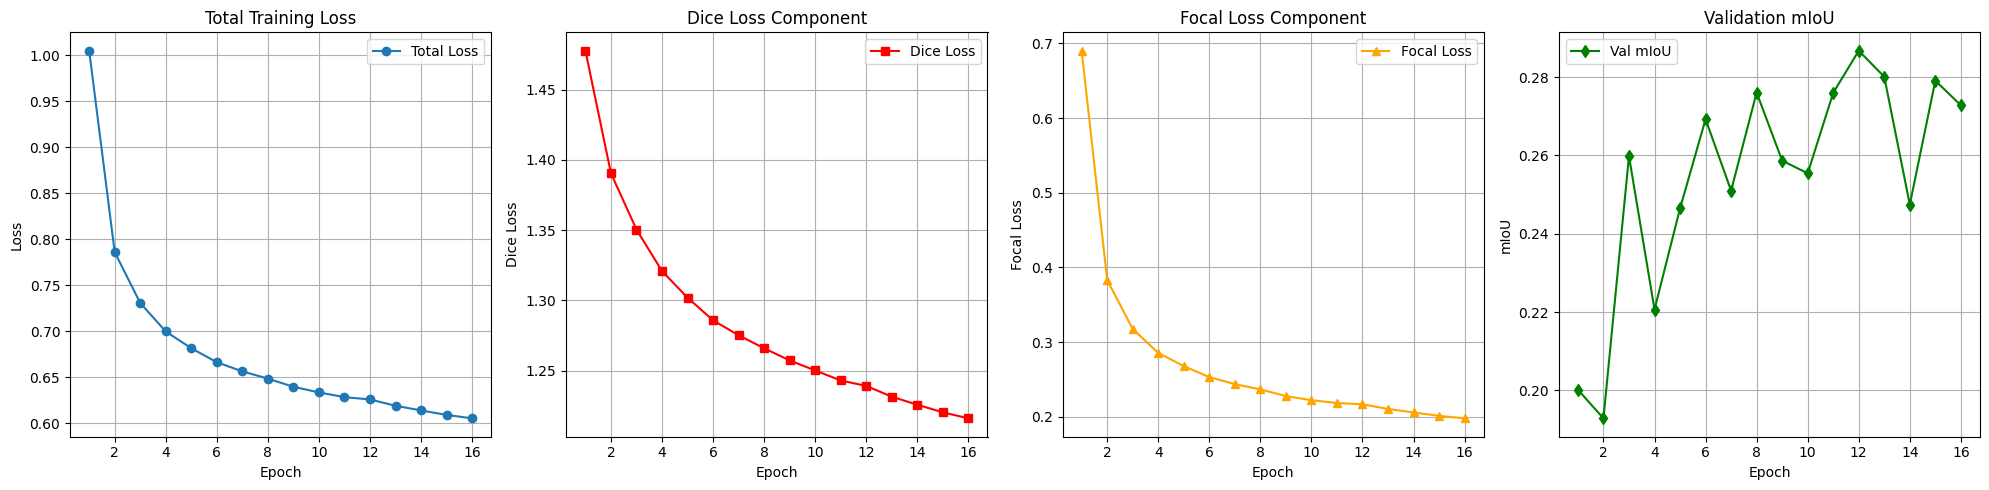

Epoch 17/50
  Total Loss: 0.6055
  Dice Loss:  1.2142
  Focal Loss: 0.1997


Per-class IoU:
  Road            : 0.7708
  Sidewalk        : 0.4034
  Building        : 0.7368
  Wall            : 0.2003
  Fence           : 0.2276
  Pole            : 0.2432
  Traffic light   : 0.2615
  Traffic sign    : 0.1509
  Vegetation      : 0.7829
  Terrain         : 0.2241
  Sky             : 0.7017
  Person          : 0.4563
  Rider           : 0.1259
  Car             : 0.5303
  Truck           : 0.1462
  Bus             : 0.1543
  Train           : 0.0458
  Motorcycle      : 0.0885
  Bicycle         : 0.0000
  Mean IoU: 0.3290


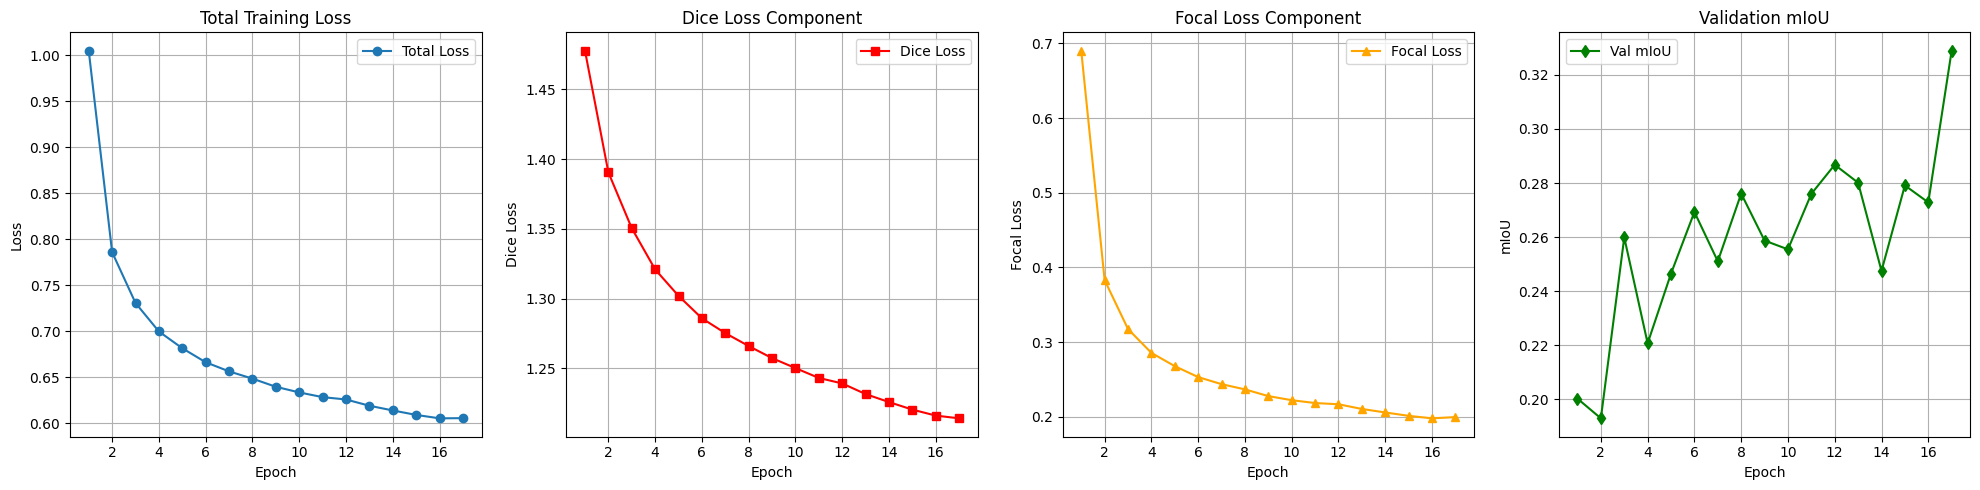

Epoch 18/50
  Total Loss: 0.6010
  Dice Loss:  1.2106
  Focal Loss: 0.1945


Per-class IoU:
  Road            : 0.6236
  Sidewalk        : 0.2084
  Building        : 0.7006
  Wall            : 0.1505
  Fence           : 0.1309
  Pole            : 0.2298
  Traffic light   : 0.2456
  Traffic sign    : 0.1451
  Vegetation      : 0.7383
  Terrain         : 0.1399
  Sky             : 0.7060
  Person          : 0.4608
  Rider           : 0.0665
  Car             : 0.4399
  Truck           : 0.0247
  Bus             : 0.0851
  Train           : 0.0171
  Motorcycle      : 0.0604
  Bicycle         : 0.0001
  Mean IoU: 0.2723


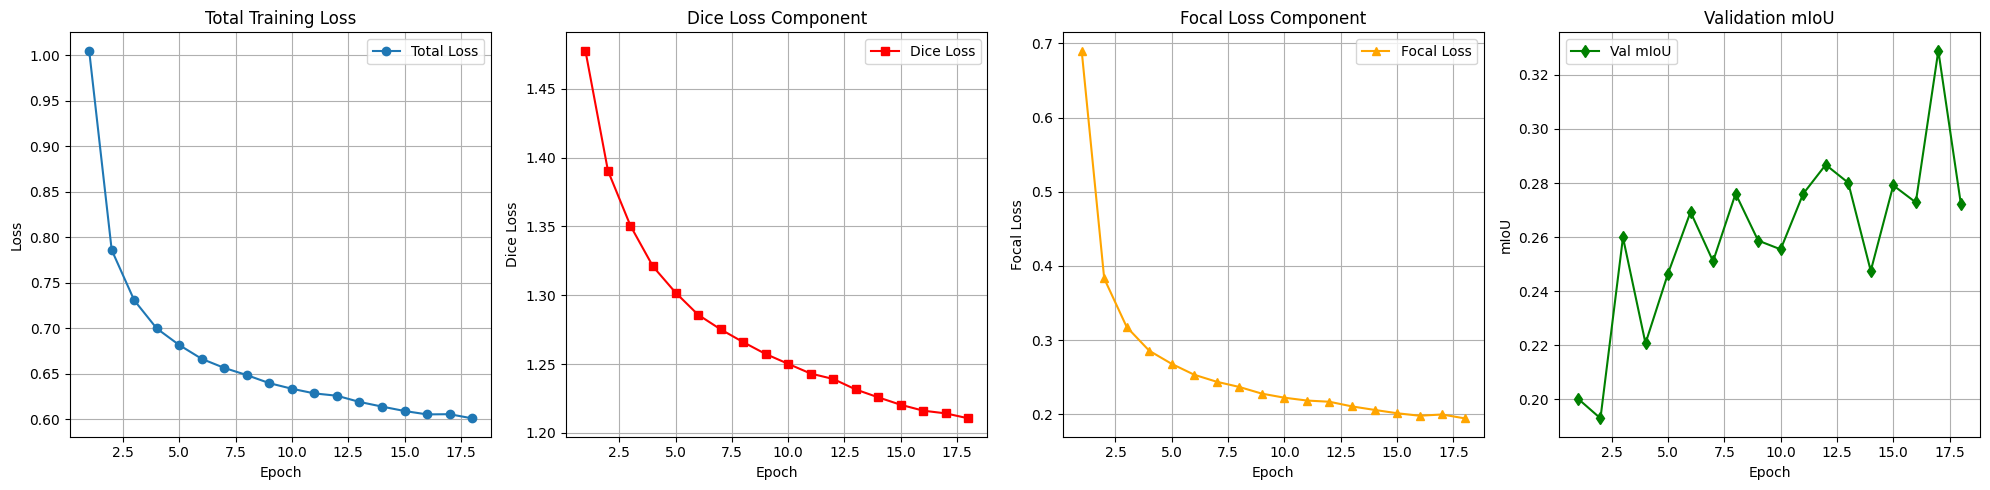

Epoch 19/50
  Total Loss: 0.6007
  Dice Loss:  1.2078
  Focal Loss: 0.1959


Per-class IoU:
  Road            : 0.4035
  Sidewalk        : 0.1984
  Building        : 0.7179
  Wall            : 0.1657
  Fence           : 0.1891
  Pole            : 0.2653
  Traffic light   : 0.2273
  Traffic sign    : 0.1958
  Vegetation      : 0.7304
  Terrain         : 0.1234
  Sky             : 0.6845
  Person          : 0.4441
  Rider           : 0.0465
  Car             : 0.2854
  Truck           : 0.0993
  Bus             : 0.0196
  Train           : 0.0163
  Motorcycle      : 0.0864
  Bicycle         : 0.0003
  Mean IoU: 0.2578


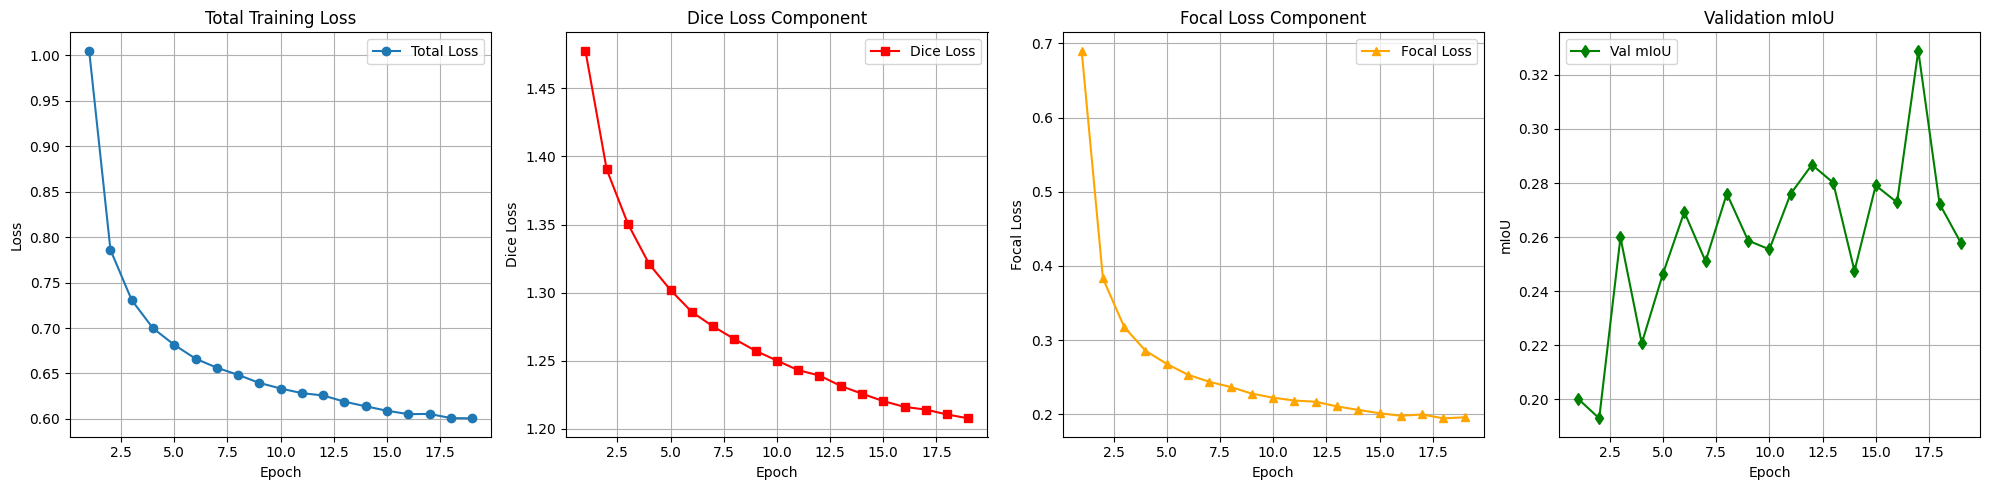

Epoch 20/50
  Total Loss: 0.5939
  Dice Loss:  1.2014
  Focal Loss: 0.1888


Per-class IoU:
  Road            : 0.3867
  Sidewalk        : 0.3675
  Building        : 0.7148
  Wall            : 0.1487
  Fence           : 0.1280
  Pole            : 0.2383
  Traffic light   : 0.2188
  Traffic sign    : 0.2118
  Vegetation      : 0.7486
  Terrain         : 0.1784
  Sky             : 0.7015
  Person          : 0.4562
  Rider           : 0.0637
  Car             : 0.2150
  Truck           : 0.0742
  Bus             : 0.1029
  Train           : 0.0134
  Motorcycle      : 0.0773
  Bicycle         : 0.0000
  Mean IoU: 0.2656
  Checkpoint saved at /content/drive/MyDrive/semantic segmentation/bisenet+loss_functions/dice+focal/checkpoint.pth


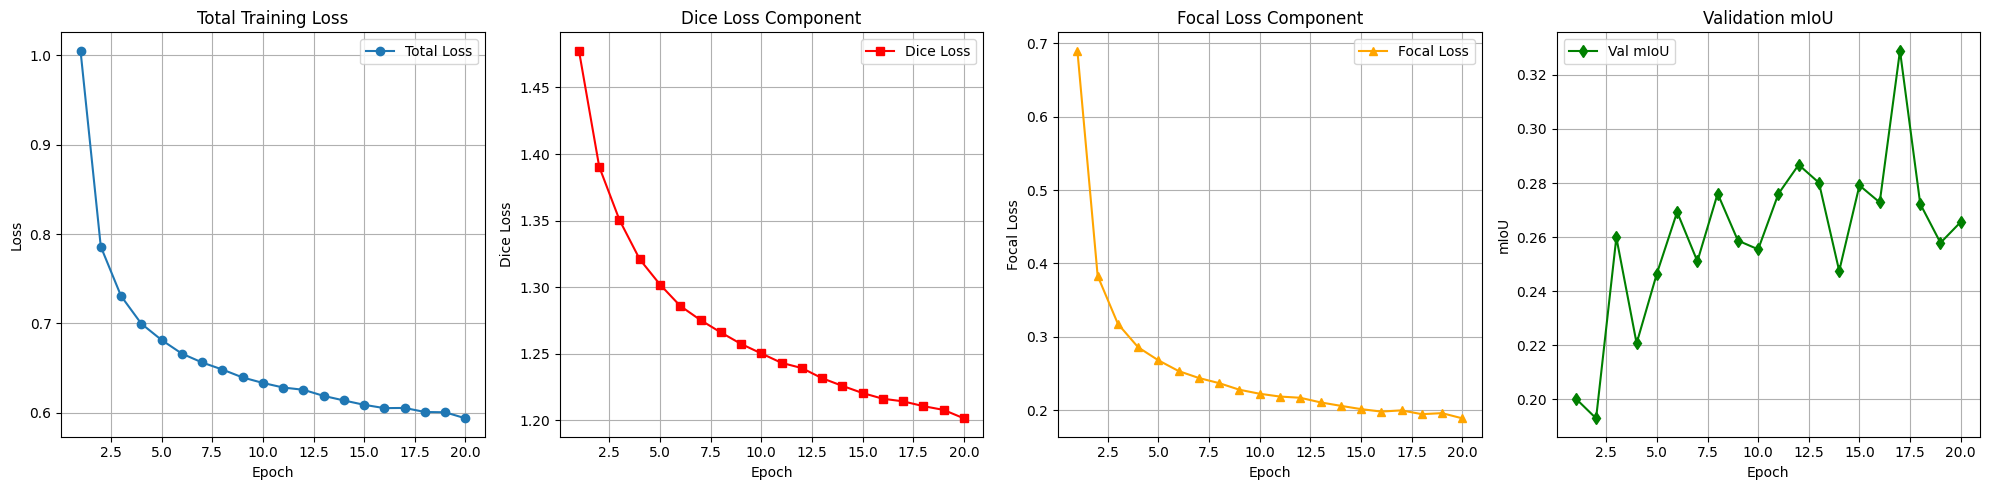

Epoch 21/50
  Total Loss: 0.5924
  Dice Loss:  1.1989
  Focal Loss: 0.1881


Per-class IoU:
  Road            : 0.6766
  Sidewalk        : 0.1970
  Building        : 0.6766
  Wall            : 0.1750
  Fence           : 0.1624
  Pole            : 0.2587
  Traffic light   : 0.2580
  Traffic sign    : 0.1288
  Vegetation      : 0.7862
  Terrain         : 0.1605
  Sky             : 0.7443
  Person          : 0.4418
  Rider           : 0.1150
  Car             : 0.4995
  Truck           : 0.0801
  Bus             : 0.1721
  Train           : 0.0009
  Motorcycle      : 0.0790
  Bicycle         : 0.0008
  Mean IoU: 0.2954


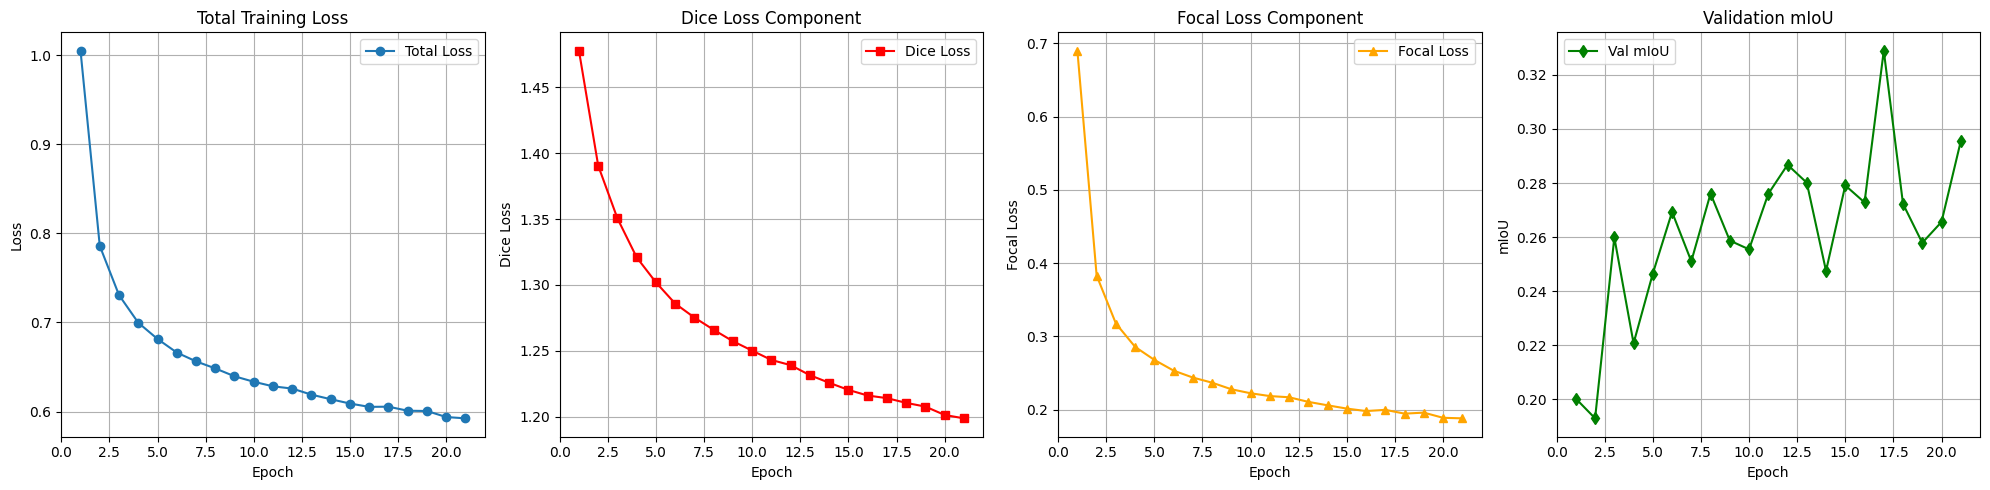

Epoch 22/50
  Total Loss: 0.5905
  Dice Loss:  1.1963
  Focal Loss: 0.1865


Per-class IoU:
  Road            : 0.6641
  Sidewalk        : 0.2555
  Building        : 0.7145
  Wall            : 0.1893
  Fence           : 0.1693
  Pole            : 0.2536
  Traffic light   : 0.2800
  Traffic sign    : 0.1606
  Vegetation      : 0.8029
  Terrain         : 0.2500
  Sky             : 0.7468
  Person          : 0.4822
  Rider           : 0.0904
  Car             : 0.3905
  Truck           : 0.1933
  Bus             : 0.2291
  Train           : 0.0000
  Motorcycle      : 0.0656
  Bicycle         : 0.0012
  Mean IoU: 0.3126


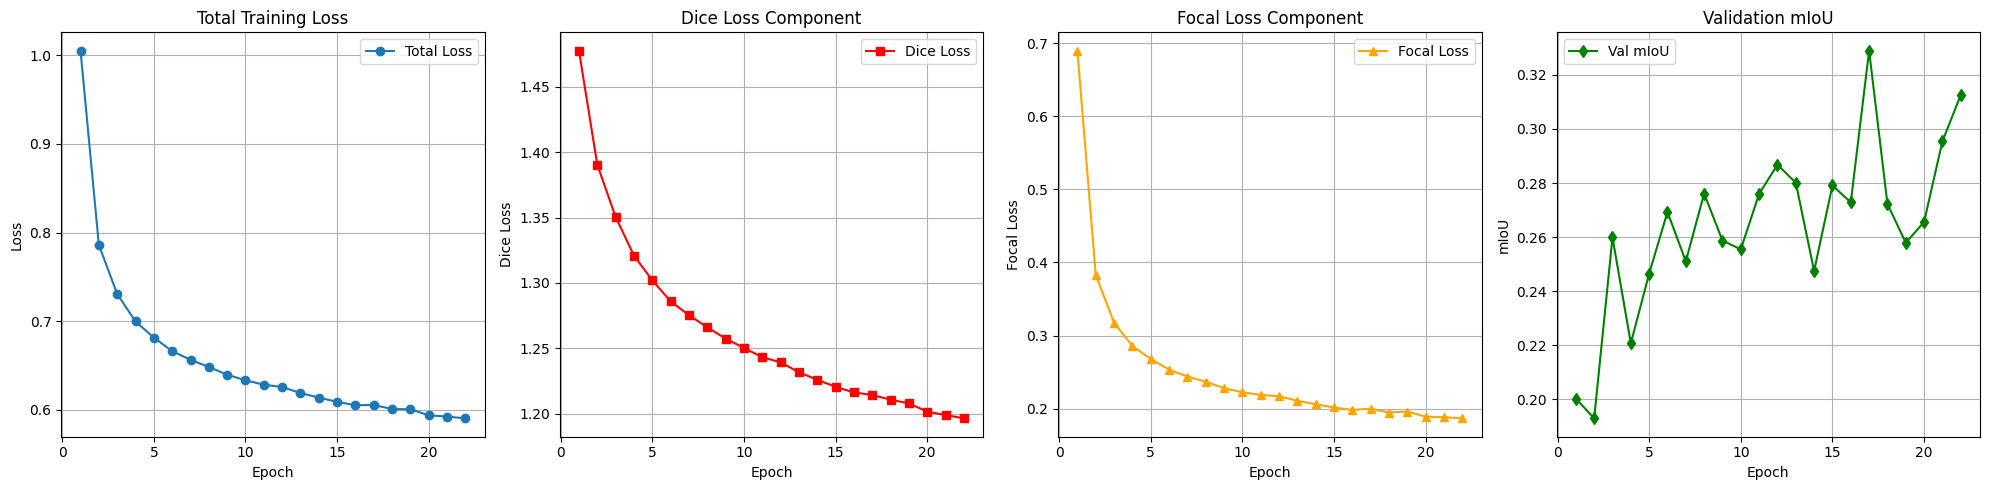

Epoch 23/50
  Total Loss: 0.5860
  Dice Loss:  1.1912
  Focal Loss: 0.1825


Per-class IoU:
  Road            : 0.4253
  Sidewalk        : 0.1999
  Building        : 0.7177
  Wall            : 0.1491
  Fence           : 0.1801
  Pole            : 0.2506
  Traffic light   : 0.2106
  Traffic sign    : 0.2303
  Vegetation      : 0.6896
  Terrain         : 0.0698
  Sky             : 0.7286
  Person          : 0.4567
  Rider           : 0.1428
  Car             : 0.2546
  Truck           : 0.1582
  Bus             : 0.0503
  Train           : 0.0112
  Motorcycle      : 0.0760
  Bicycle         : 0.0010
  Mean IoU: 0.2633


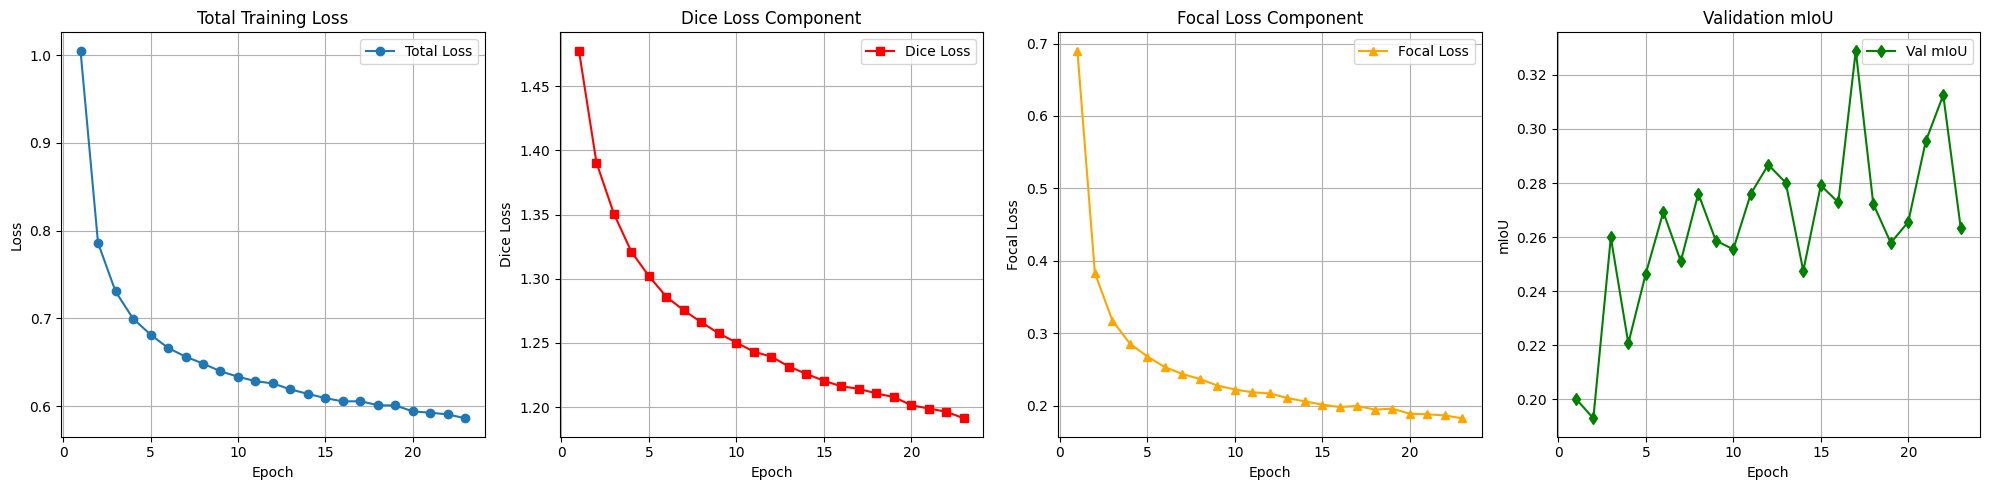

Epoch 24/50
  Total Loss: 0.5838
  Dice Loss:  1.1884
  Focal Loss: 0.1808


Per-class IoU:
  Road            : 0.3937
  Sidewalk        : 0.2537
  Building        : 0.7134
  Wall            : 0.1259
  Fence           : 0.1390
  Pole            : 0.2308
  Traffic light   : 0.2516
  Traffic sign    : 0.1774
  Vegetation      : 0.7623
  Terrain         : 0.0821
  Sky             : 0.7176
  Person          : 0.4673
  Rider           : 0.1083
  Car             : 0.2612
  Truck           : 0.2264
  Bus             : 0.0837
  Train           : 0.0246
  Motorcycle      : 0.0792
  Bicycle         : 0.0164
  Mean IoU: 0.2692


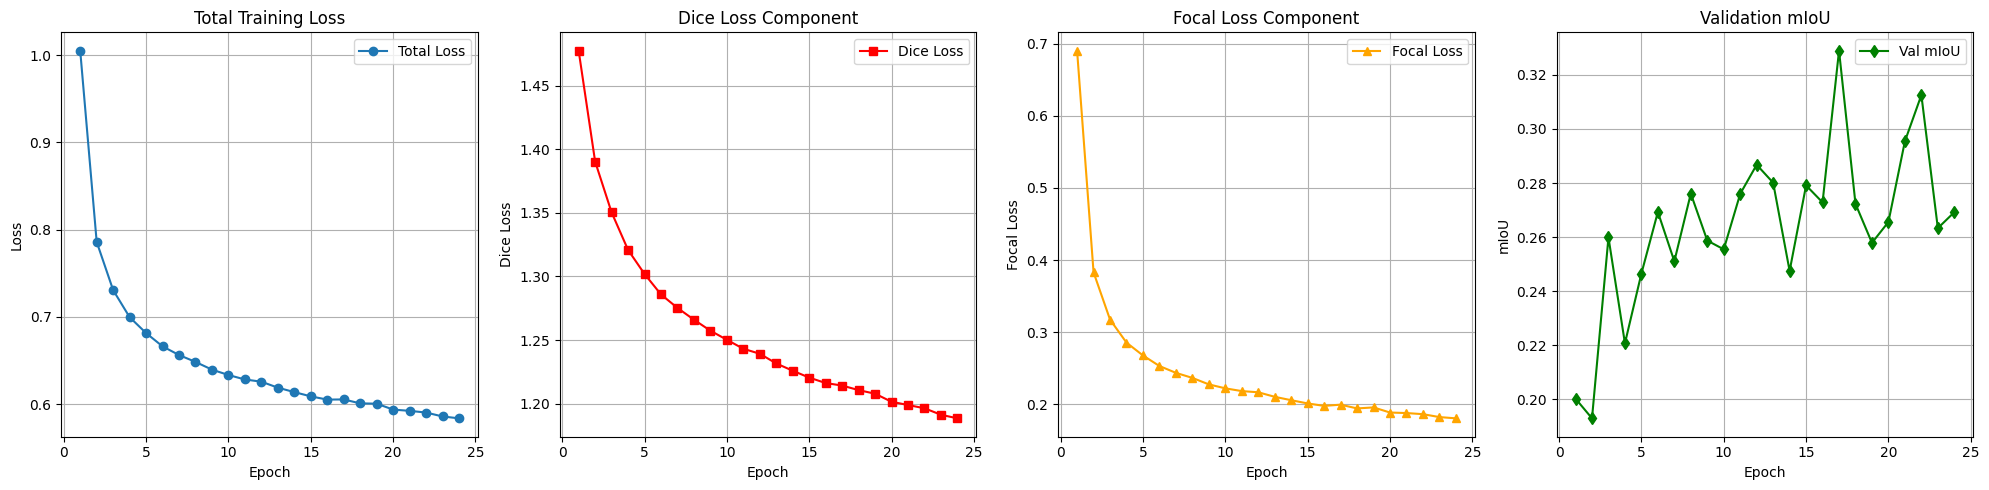

Epoch 25/50
  Total Loss: 0.5795
  Dice Loss:  1.1836
  Focal Loss: 0.1768


Per-class IoU:
  Road            : 0.5023
  Sidewalk        : 0.2305
  Building        : 0.7158
  Wall            : 0.1361
  Fence           : 0.2047
  Pole            : 0.2662
  Traffic light   : 0.2623
  Traffic sign    : 0.1766
  Vegetation      : 0.7627
  Terrain         : 0.1372
  Sky             : 0.7228
  Person          : 0.4707
  Rider           : 0.1421
  Car             : 0.3124
  Truck           : 0.1288
  Bus             : 0.1148
  Train           : 0.0108
  Motorcycle      : 0.0880
  Bicycle         : 0.0485
  Mean IoU: 0.2860
  Checkpoint saved at /content/drive/MyDrive/semantic segmentation/bisenet+loss_functions/dice+focal/checkpoint.pth


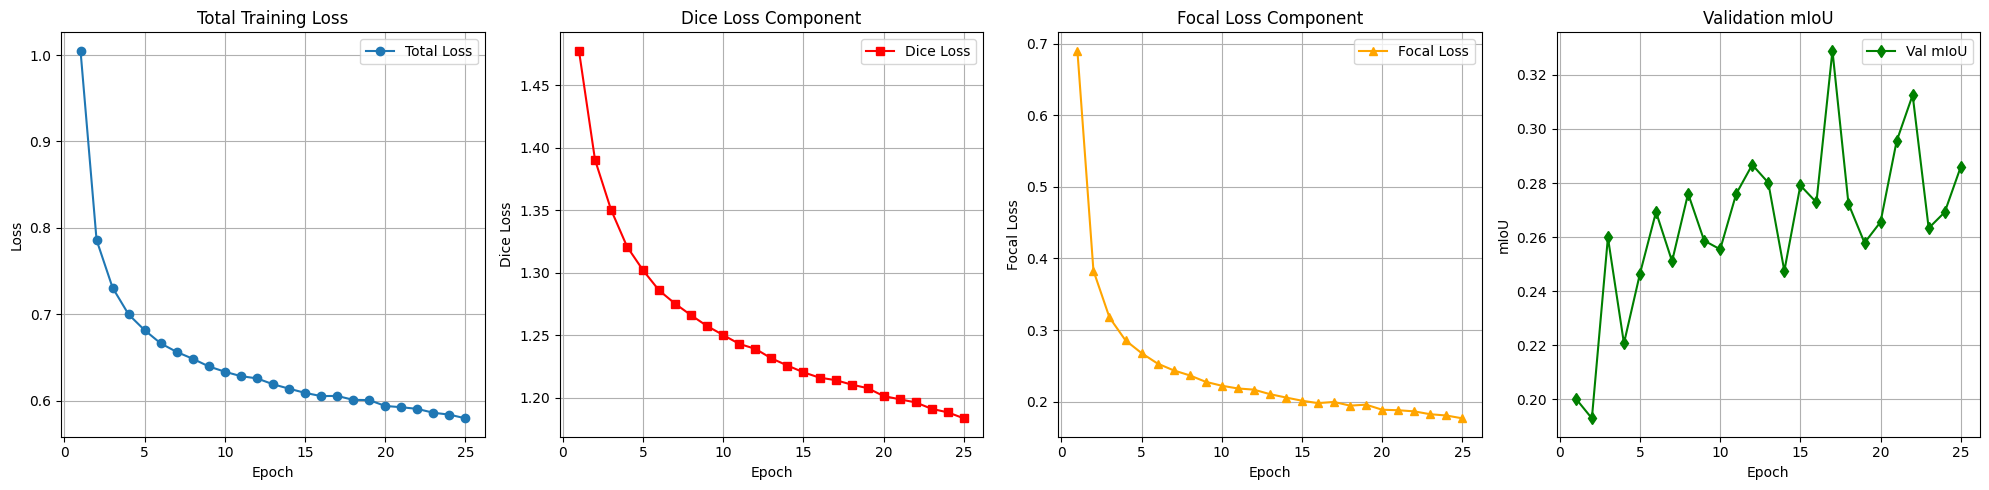

Epoch 26/50
  Total Loss: 0.5791
  Dice Loss:  1.1827
  Focal Loss: 0.1768


Per-class IoU:
  Road            : 0.7021
  Sidewalk        : 0.2901
  Building        : 0.7491
  Wall            : 0.1431
  Fence           : 0.1485
  Pole            : 0.2336
  Traffic light   : 0.2770
  Traffic sign    : 0.1534
  Vegetation      : 0.7818
  Terrain         : 0.2057
  Sky             : 0.7201
  Person          : 0.4670
  Rider           : 0.0622
  Car             : 0.4028
  Truck           : 0.2027
  Bus             : 0.2475
  Train           : 0.0114
  Motorcycle      : 0.0635
  Bicycle         : 0.0280
  Mean IoU: 0.3100


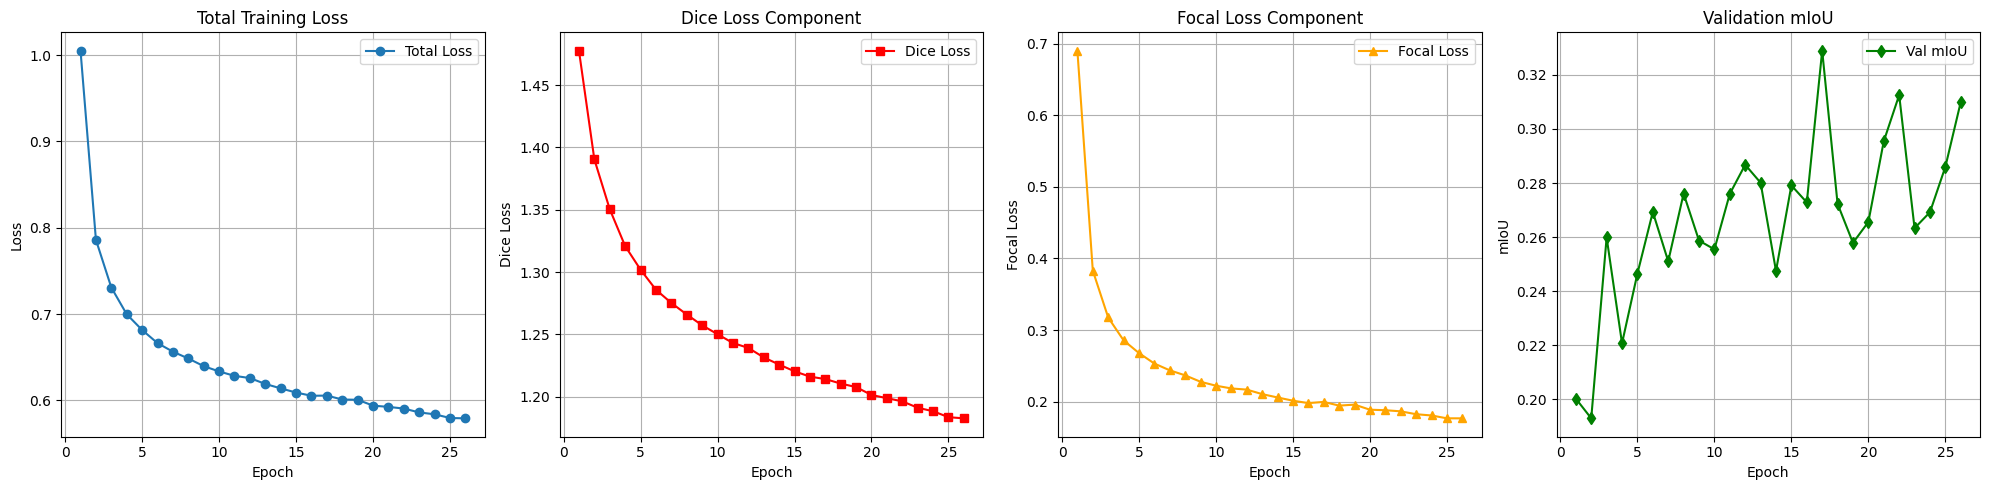

Epoch 27/50
  Total Loss: 0.5773
  Dice Loss:  1.1801
  Focal Loss: 0.1754


Per-class IoU:
  Road            : 0.3245
  Sidewalk        : 0.3047
  Building        : 0.7218
  Wall            : 0.1594
  Fence           : 0.2070
  Pole            : 0.2387
  Traffic light   : 0.2671
  Traffic sign    : 0.1131
  Vegetation      : 0.7454
  Terrain         : 0.1470
  Sky             : 0.6580
  Person          : 0.4718
  Rider           : 0.0987
  Car             : 0.2208
  Truck           : 0.0513
  Bus             : 0.0921
  Train           : 0.0151
  Motorcycle      : 0.0699
  Bicycle         : 0.0122
  Mean IoU: 0.2589


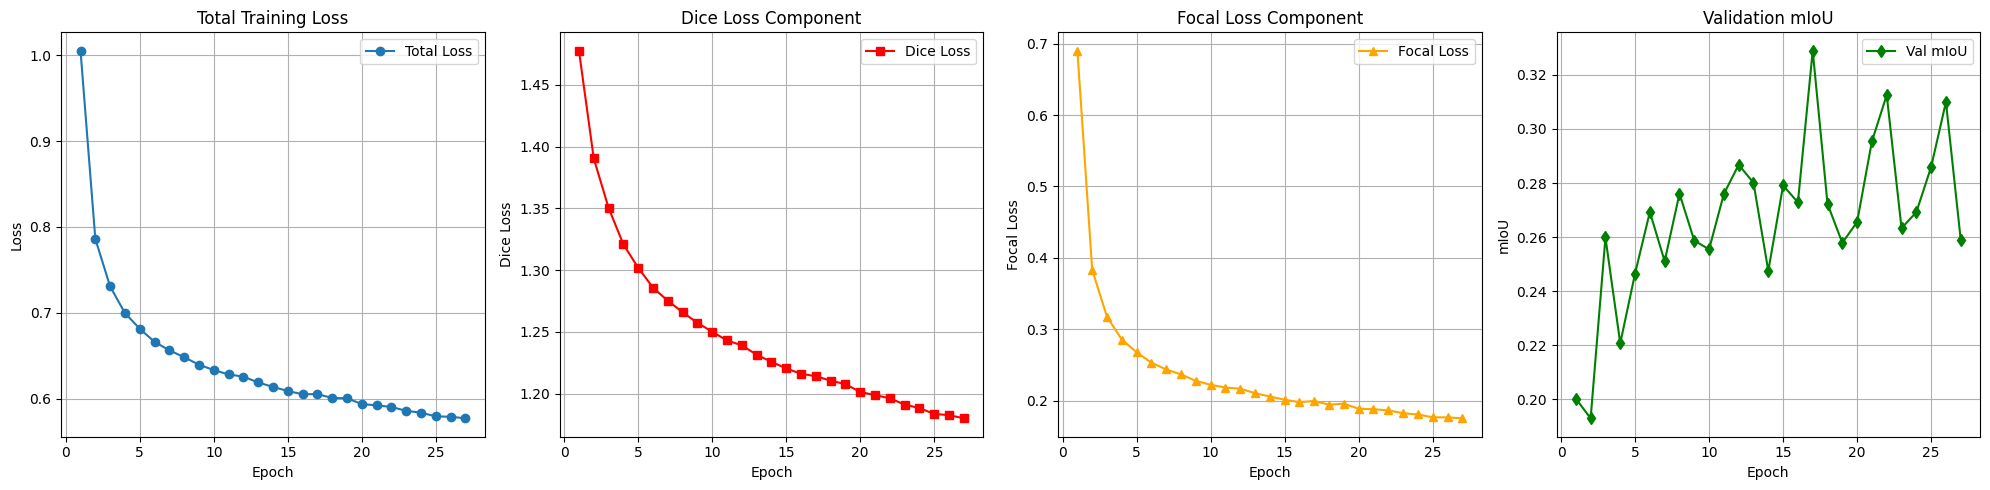

Epoch 28/50
  Total Loss: 0.5752
  Dice Loss:  1.1779
  Focal Loss: 0.1734


Per-class IoU:
  Road            : 0.4849
  Sidewalk        : 0.2647
  Building        : 0.7149
  Wall            : 0.1556
  Fence           : 0.1735
  Pole            : 0.2512
  Traffic light   : 0.2384
  Traffic sign    : 0.0891
  Vegetation      : 0.7770
  Terrain         : 0.1356
  Sky             : 0.6386
  Person          : 0.4692
  Rider           : 0.0874
  Car             : 0.3242
  Truck           : 0.0300
  Bus             : 0.0731
  Train           : 0.0082
  Motorcycle      : 0.0746
  Bicycle         : 0.0457
  Mean IoU: 0.2650


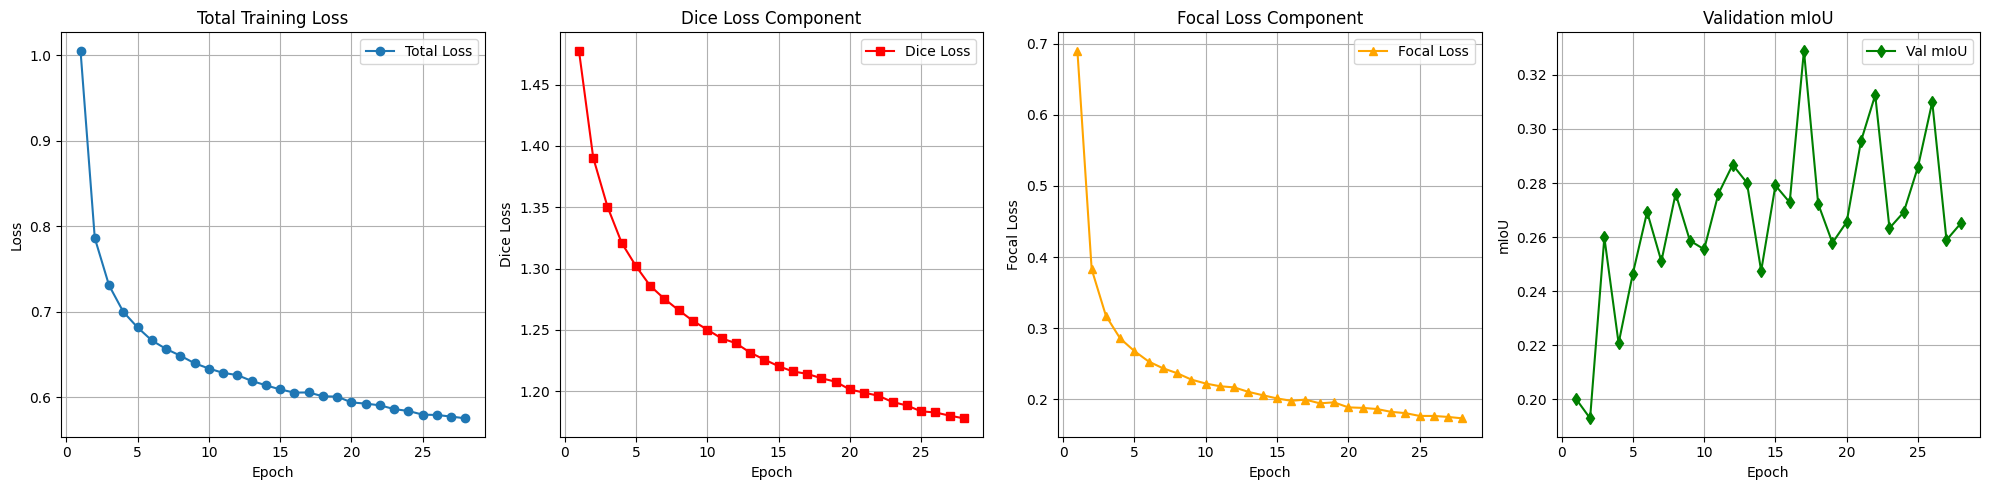

Epoch 29/50
  Total Loss: 0.5728
  Dice Loss:  1.1745
  Focal Loss: 0.1716


Per-class IoU:
  Road            : 0.4799
  Sidewalk        : 0.2369
  Building        : 0.7181
  Wall            : 0.1504
  Fence           : 0.1867
  Pole            : 0.2507
  Traffic light   : 0.2372
  Traffic sign    : 0.1900
  Vegetation      : 0.7417
  Terrain         : 0.0860
  Sky             : 0.6767
  Person          : 0.4519
  Rider           : 0.1347
  Car             : 0.2980
  Truck           : 0.1269
  Bus             : 0.0551
  Train           : 0.0141
  Motorcycle      : 0.0670
  Bicycle         : 0.0987
  Mean IoU: 0.2737


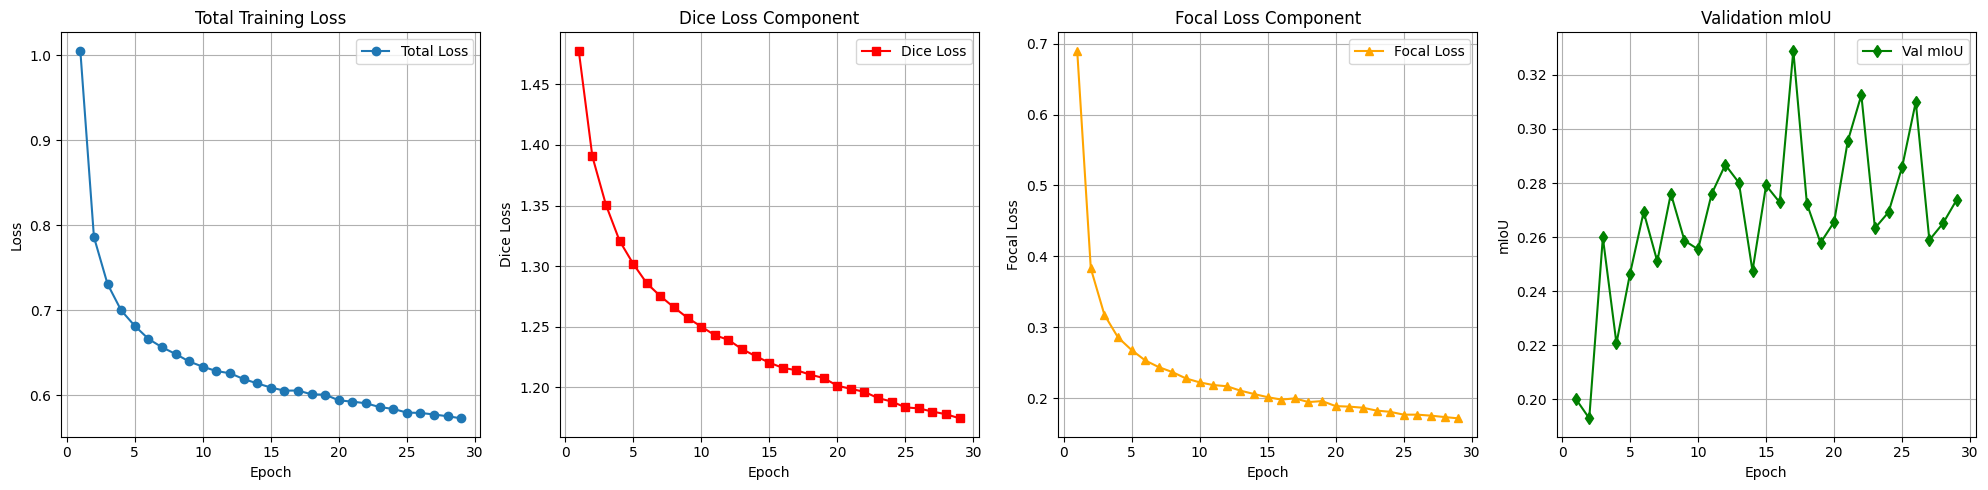

Epoch 30/50
  Total Loss: 0.5748
  Dice Loss:  1.1752
  Focal Loss: 0.1745


Per-class IoU:
  Road            : 0.3841
  Sidewalk        : 0.2184
  Building        : 0.7305
  Wall            : 0.1315
  Fence           : 0.1762
  Pole            : 0.2615
  Traffic light   : 0.2474
  Traffic sign    : 0.1271
  Vegetation      : 0.6623
  Terrain         : 0.0498
  Sky             : 0.6951
  Person          : 0.4758
  Rider           : 0.0762
  Car             : 0.2859
  Truck           : 0.0605
  Bus             : 0.0518
  Train           : 0.0170
  Motorcycle      : 0.0771
  Bicycle         : 0.0339
  Mean IoU: 0.2506
  Checkpoint saved at /content/drive/MyDrive/semantic segmentation/bisenet+loss_functions/dice+focal/checkpoint.pth


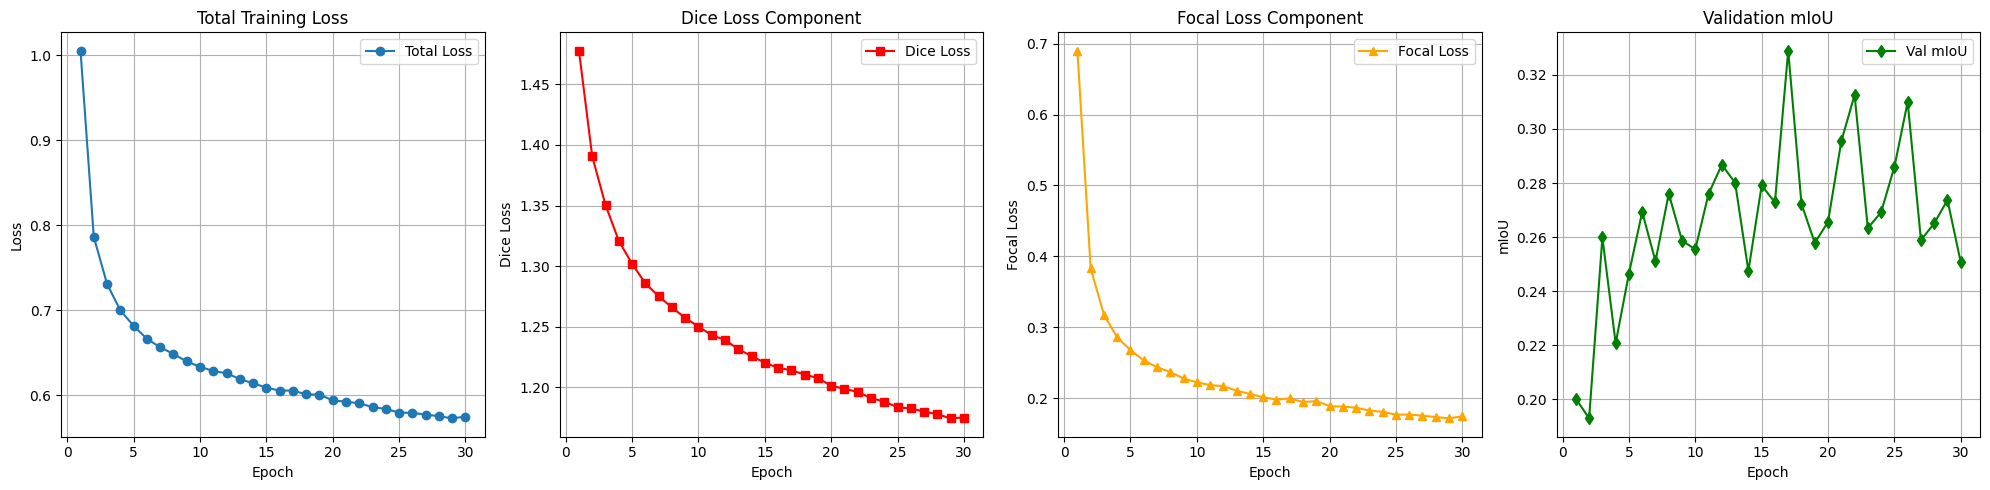

Epoch 31/50
  Total Loss: 0.5695
  Dice Loss:  1.1709
  Focal Loss: 0.1686


Per-class IoU:
  Road            : 0.5189
  Sidewalk        : 0.2410
  Building        : 0.7109
  Wall            : 0.1078
  Fence           : 0.1391
  Pole            : 0.2336
  Traffic light   : 0.2709
  Traffic sign    : 0.1491
  Vegetation      : 0.7680
  Terrain         : 0.0895
  Sky             : 0.6874
  Person          : 0.4500
  Rider           : 0.1727
  Car             : 0.3249
  Truck           : 0.1813
  Bus             : 0.1047
  Train           : 0.0141
  Motorcycle      : 0.0790
  Bicycle         : 0.1265
  Mean IoU: 0.2826


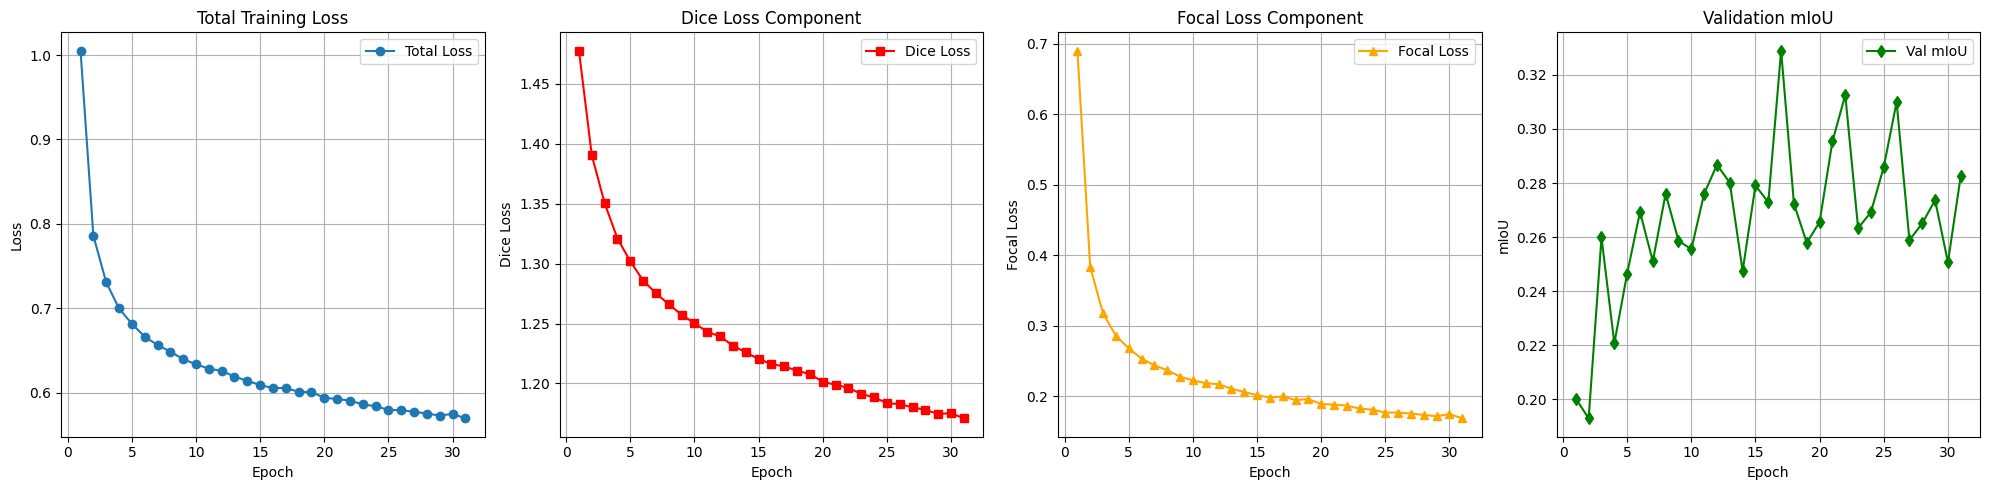

Epoch 32/50
  Total Loss: 0.5681
  Dice Loss:  1.1684
  Focal Loss: 0.1679


Per-class IoU:
  Road            : 0.4147
  Sidewalk        : 0.3608
  Building        : 0.7286
  Wall            : 0.1626
  Fence           : 0.1985
  Pole            : 0.2526
  Traffic light   : 0.2340
  Traffic sign    : 0.1747
  Vegetation      : 0.7892
  Terrain         : 0.1487
  Sky             : 0.5781
  Person          : 0.4725
  Rider           : 0.1598
  Car             : 0.2902
  Truck           : 0.0233
  Bus             : 0.0797
  Train           : 0.0070
  Motorcycle      : 0.1029
  Bicycle         : 0.1244
  Mean IoU: 0.2791


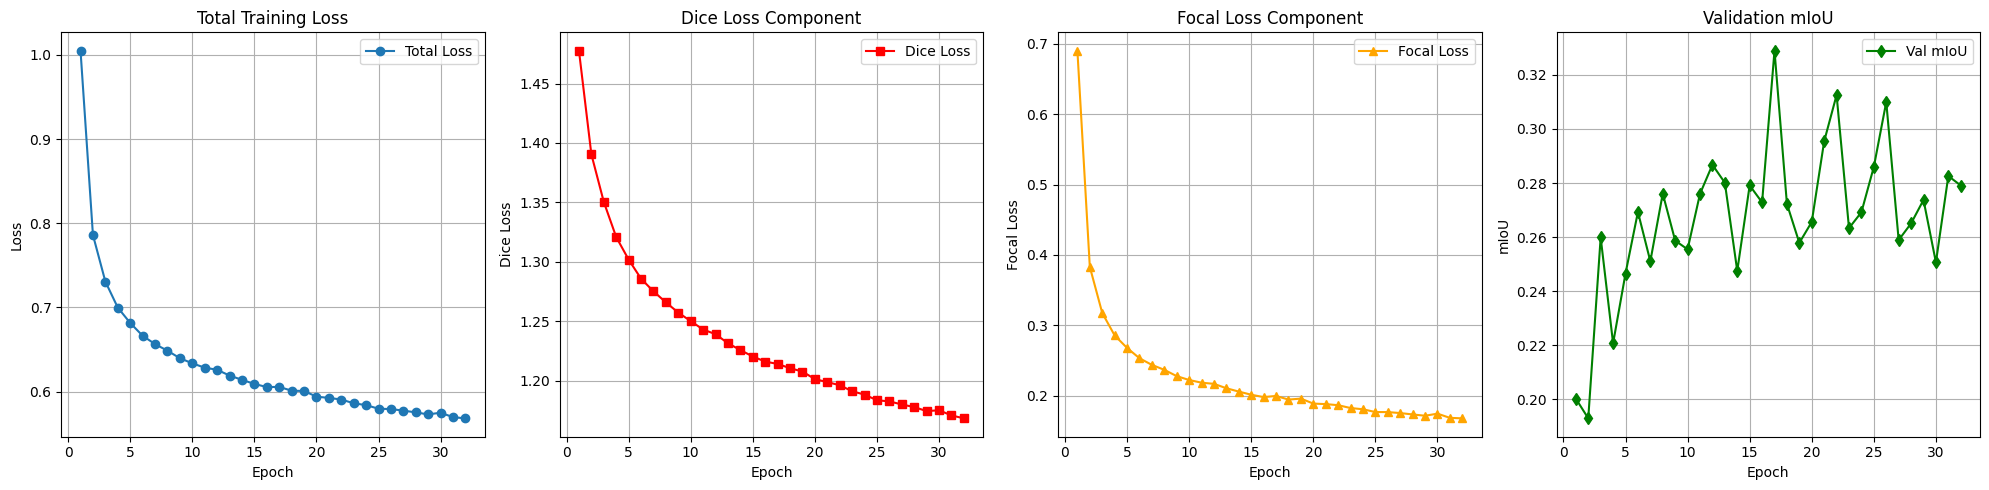

Epoch 33/50
  Total Loss: 0.5674
  Dice Loss:  1.1677
  Focal Loss: 0.1672


Per-class IoU:
  Road            : 0.5474
  Sidewalk        : 0.2674
  Building        : 0.7242
  Wall            : 0.1660
  Fence           : 0.1903
  Pole            : 0.2635
  Traffic light   : 0.2817
  Traffic sign    : 0.1130
  Vegetation      : 0.7729
  Terrain         : 0.2236
  Sky             : 0.6794
  Person          : 0.4743
  Rider           : 0.1062
  Car             : 0.2982
  Truck           : 0.0907
  Bus             : 0.1058
  Train           : 0.0061
  Motorcycle      : 0.0801
  Bicycle         : 0.0400
  Mean IoU: 0.2858


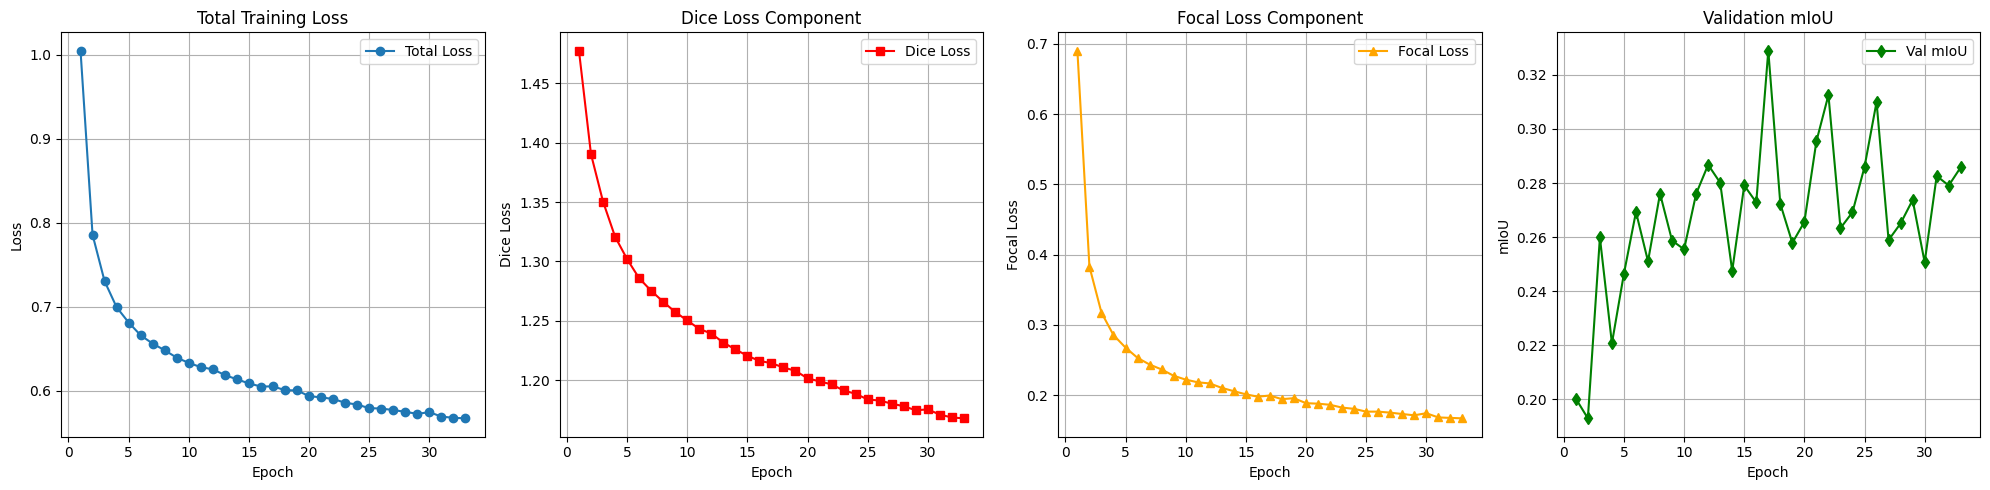

Epoch 34/50
  Total Loss: 0.5653
  Dice Loss:  1.1649
  Focal Loss: 0.1656


Per-class IoU:
  Road            : 0.6608
  Sidewalk        : 0.2846
  Building        : 0.7427
  Wall            : 0.1689
  Fence           : 0.1846
  Pole            : 0.2448
  Traffic light   : 0.2540
  Traffic sign    : 0.1665
  Vegetation      : 0.7675
  Terrain         : 0.1033
  Sky             : 0.7023
  Person          : 0.4377
  Rider           : 0.1462
  Car             : 0.4450
  Truck           : 0.0691
  Bus             : 0.1079
  Train           : 0.0422
  Motorcycle      : 0.0900
  Bicycle         : 0.1038
  Mean IoU: 0.3012


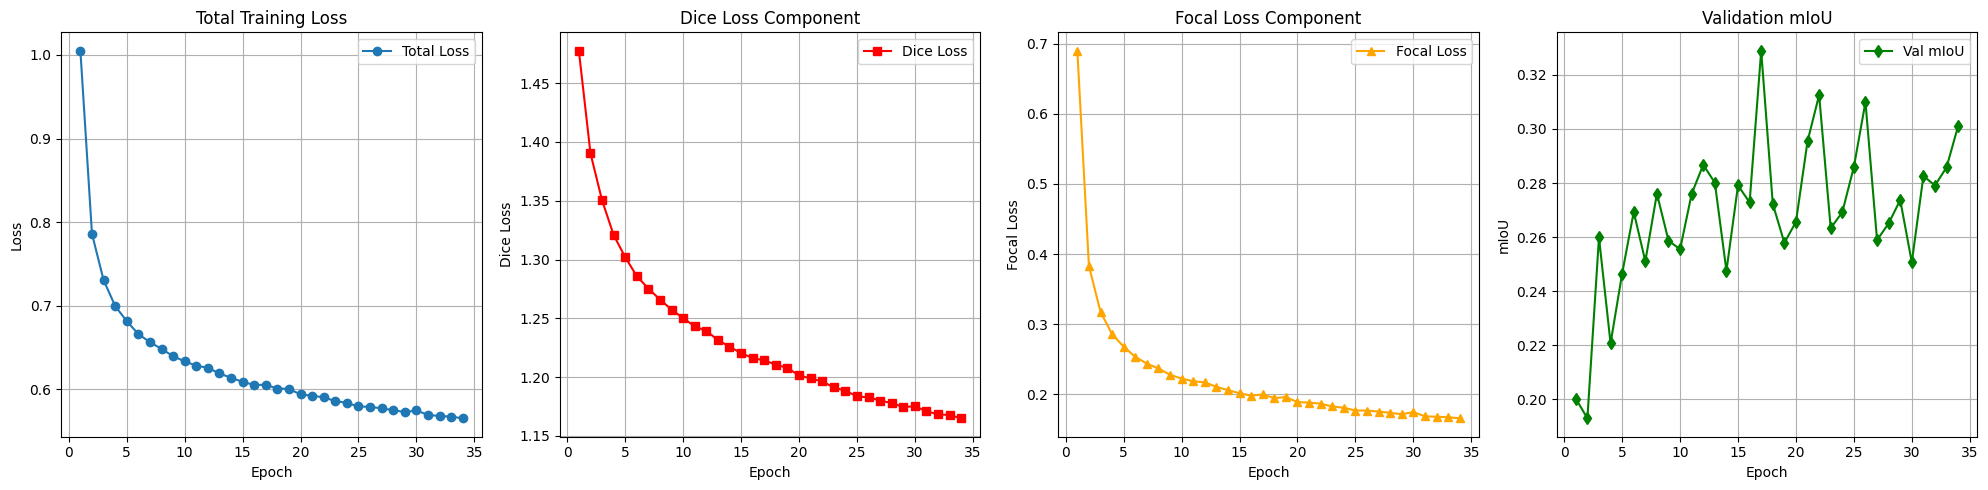

Epoch 35/50
  Total Loss: 0.5639
  Dice Loss:  1.1633
  Focal Loss: 0.1642


Per-class IoU:
  Road            : 0.5446
  Sidewalk        : 0.3071
  Building        : 0.7138
  Wall            : 0.1314
  Fence           : 0.1853
  Pole            : 0.2778
  Traffic light   : 0.2849
  Traffic sign    : 0.1419
  Vegetation      : 0.7892
  Terrain         : 0.1303
  Sky             : 0.6616
  Person          : 0.4489
  Rider           : 0.1067
  Car             : 0.3341
  Truck           : 0.0605
  Bus             : 0.1595
  Train           : 0.0250
  Motorcycle      : 0.0809
  Bicycle         : 0.0411
  Mean IoU: 0.2855
  Checkpoint saved at /content/drive/MyDrive/semantic segmentation/bisenet+loss_functions/dice+focal/checkpoint.pth


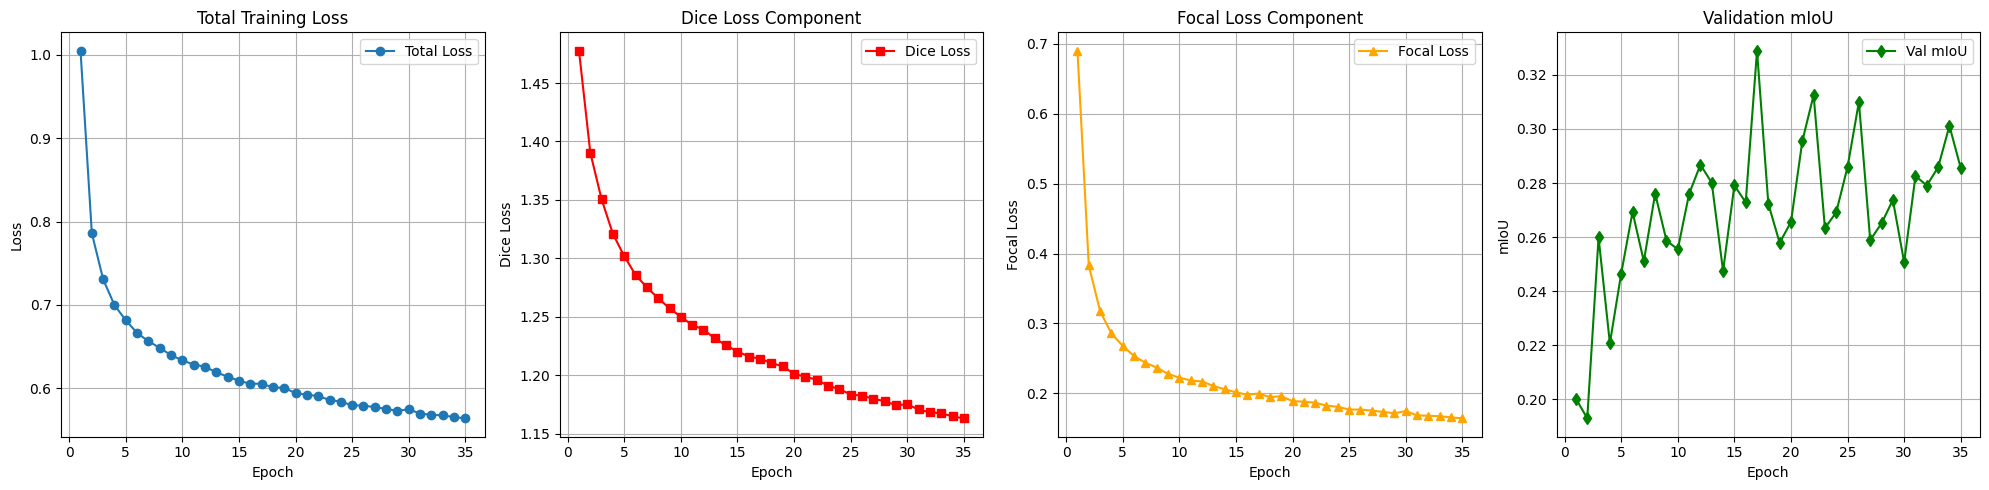

Epoch 36/50
  Total Loss: 0.5631
  Dice Loss:  1.1620
  Focal Loss: 0.1638


Per-class IoU:
  Road            : 0.5188
  Sidewalk        : 0.3123
  Building        : 0.7391
  Wall            : 0.1558
  Fence           : 0.1766
  Pole            : 0.2590
  Traffic light   : 0.2848
  Traffic sign    : 0.1540
  Vegetation      : 0.7394
  Terrain         : 0.1046
  Sky             : 0.6479
  Person          : 0.4964
  Rider           : 0.1477
  Car             : 0.2961
  Truck           : 0.1350
  Bus             : 0.1379
  Train           : 0.0365
  Motorcycle      : 0.0775
  Bicycle         : 0.0572
  Mean IoU: 0.2882


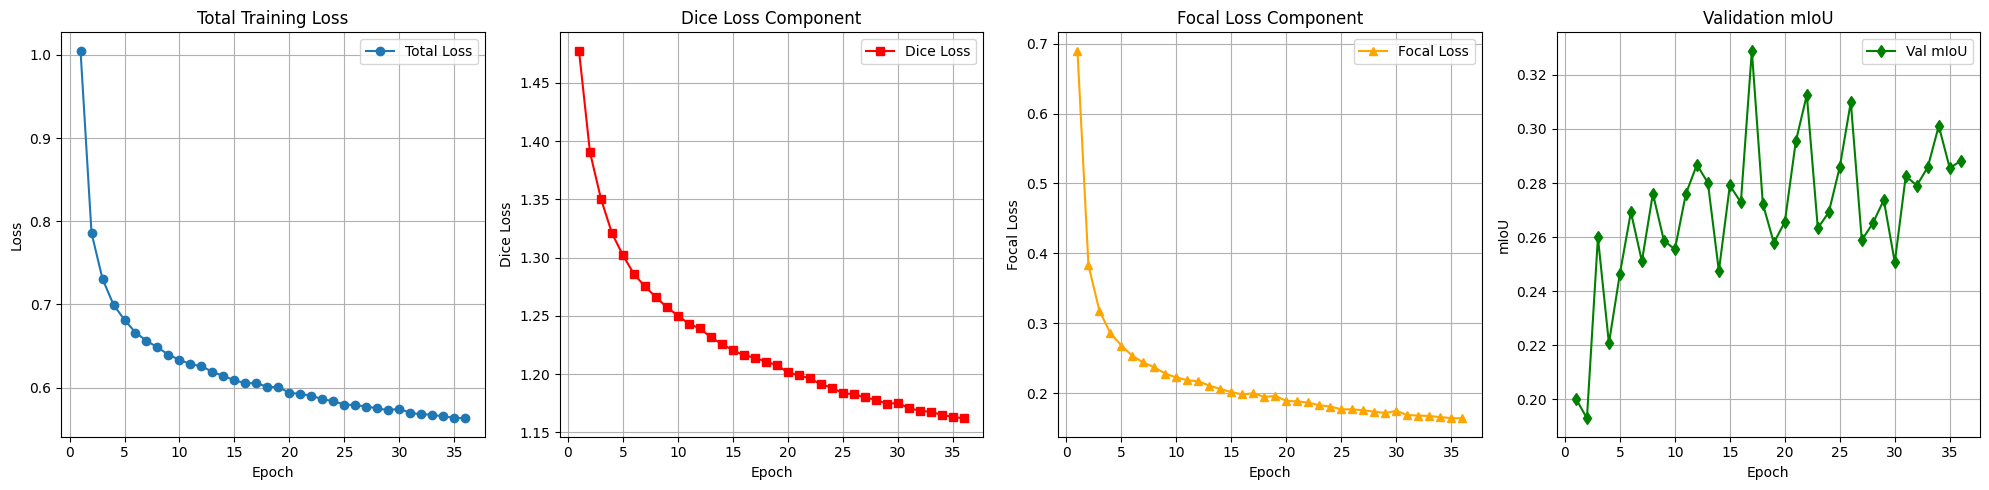

Epoch 37/50
  Total Loss: 0.5629
  Dice Loss:  1.1619
  Focal Loss: 0.1636


Per-class IoU:
  Road            : 0.4738
  Sidewalk        : 0.3018
  Building        : 0.7402
  Wall            : 0.1634
  Fence           : 0.1864
  Pole            : 0.2328
  Traffic light   : 0.2805
  Traffic sign    : 0.1727
  Vegetation      : 0.7487
  Terrain         : 0.1123
  Sky             : 0.6997
  Person          : 0.4910
  Rider           : 0.1320
  Car             : 0.2784
  Truck           : 0.0780
  Bus             : 0.1327
  Train           : 0.0214
  Motorcycle      : 0.0854
  Bicycle         : 0.0587
  Mean IoU: 0.2837


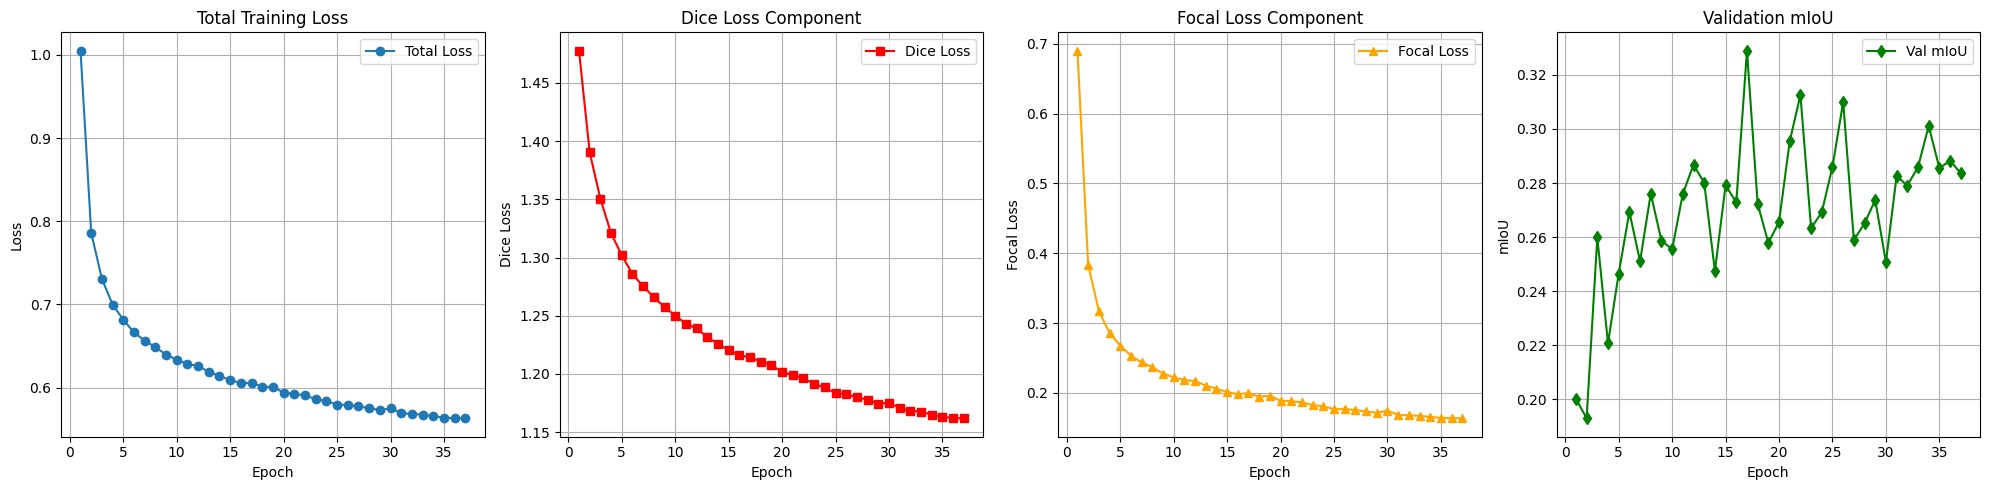

Epoch 38/50
  Total Loss: 0.5609
  Dice Loss:  1.1590
  Focal Loss: 0.1621


Per-class IoU:
  Road            : 0.4239
  Sidewalk        : 0.3023
  Building        : 0.7545
  Wall            : 0.1366
  Fence           : 0.1551
  Pole            : 0.2428
  Traffic light   : 0.2456
  Traffic sign    : 0.1217
  Vegetation      : 0.7704
  Terrain         : 0.2099
  Sky             : 0.6928
  Person          : 0.4811
  Rider           : 0.1395
  Car             : 0.2248
  Truck           : 0.0706
  Bus             : 0.1281
  Train           : 0.0317
  Motorcycle      : 0.0924
  Bicycle         : 0.0981
  Mean IoU: 0.2801


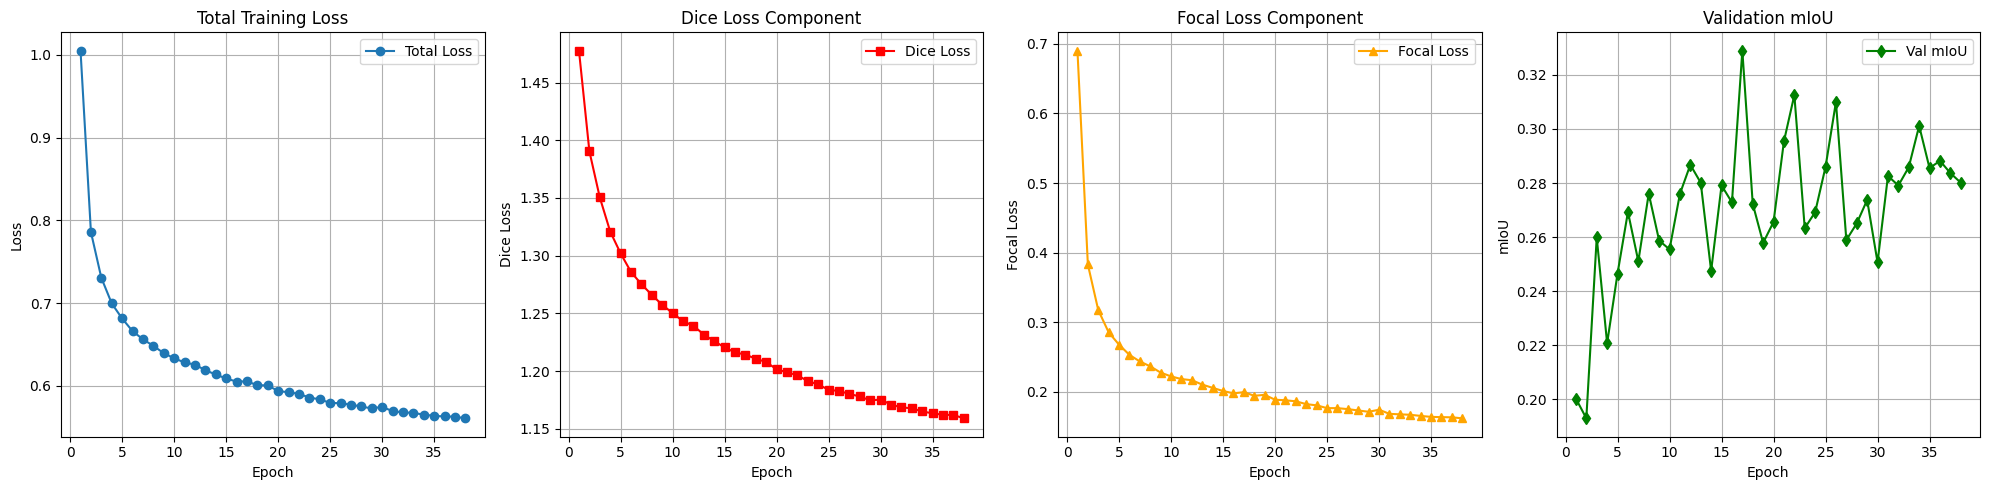

Epoch 39/50
  Total Loss: 0.5591
  Dice Loss:  1.1574
  Focal Loss: 0.1602


Per-class IoU:
  Road            : 0.5353
  Sidewalk        : 0.2745
  Building        : 0.7299
  Wall            : 0.1564
  Fence           : 0.2016
  Pole            : 0.2708
  Traffic light   : 0.2515
  Traffic sign    : 0.1530
  Vegetation      : 0.7684
  Terrain         : 0.1003
  Sky             : 0.6426
  Person          : 0.4862
  Rider           : 0.1276
  Car             : 0.2997
  Truck           : 0.1193
  Bus             : 0.1457
  Train           : 0.0542
  Motorcycle      : 0.0801
  Bicycle         : 0.0708
  Mean IoU: 0.2878


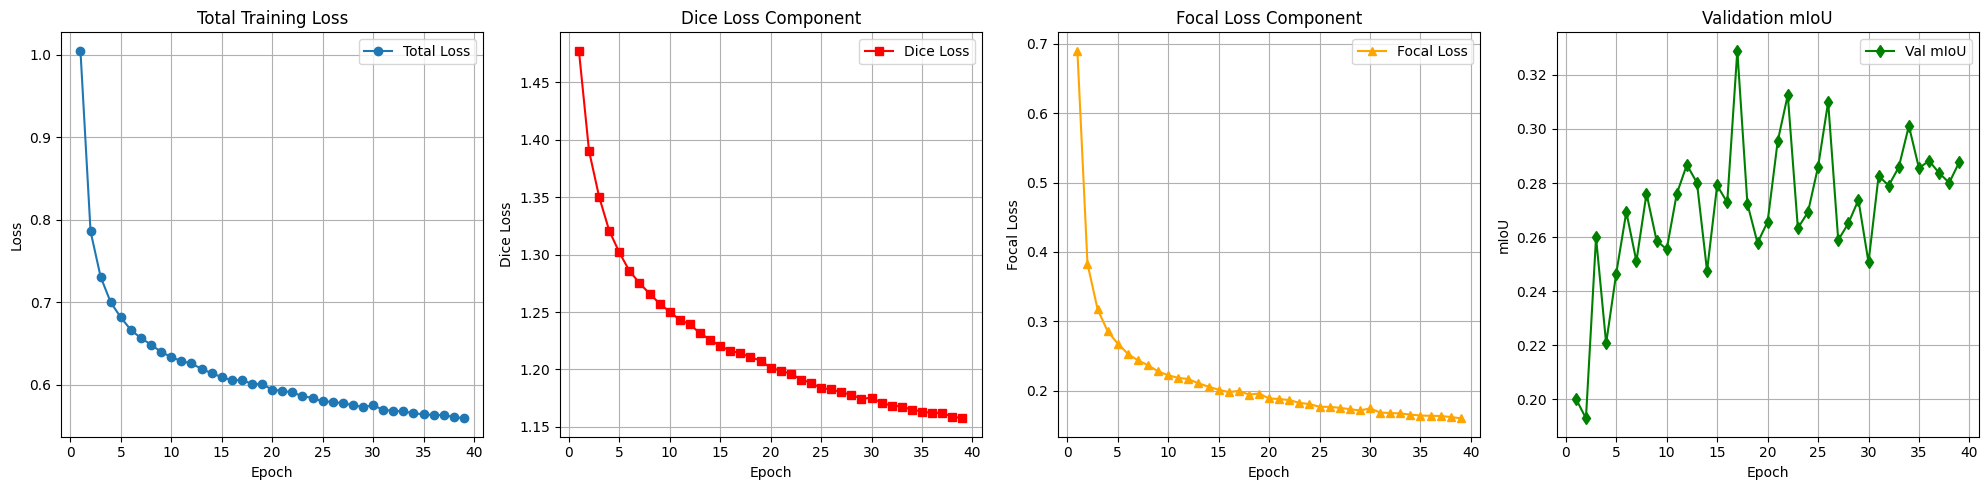

Epoch 40/50
  Total Loss: 0.5576
  Dice Loss:  1.1545
  Focal Loss: 0.1596


Per-class IoU:
  Road            : 0.4870
  Sidewalk        : 0.3182
  Building        : 0.7121
  Wall            : 0.1444
  Fence           : 0.1715
  Pole            : 0.2511
  Traffic light   : 0.2929
  Traffic sign    : 0.1567
  Vegetation      : 0.7845
  Terrain         : 0.1849
  Sky             : 0.6518
  Person          : 0.4724
  Rider           : 0.1330
  Car             : 0.2705
  Truck           : 0.1541
  Bus             : 0.1258
  Train           : 0.0401
  Motorcycle      : 0.0897
  Bicycle         : 0.0822
  Mean IoU: 0.2907
  Checkpoint saved at /content/drive/MyDrive/semantic segmentation/bisenet+loss_functions/dice+focal/checkpoint.pth


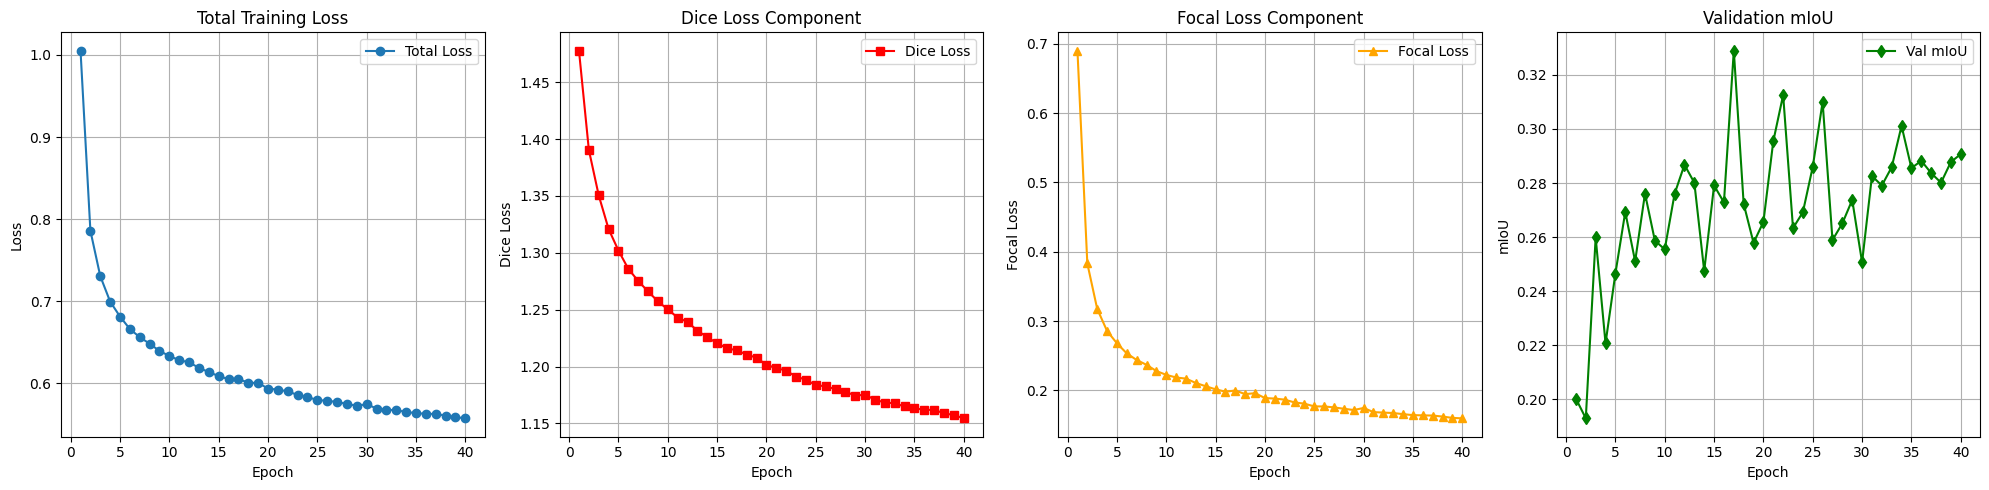

Epoch 41/50
  Total Loss: 0.5568
  Dice Loss:  1.1536
  Focal Loss: 0.1589


Per-class IoU:
  Road            : 0.4573
  Sidewalk        : 0.3395
  Building        : 0.7440
  Wall            : 0.1694
  Fence           : 0.2049
  Pole            : 0.2677
  Traffic light   : 0.2837
  Traffic sign    : 0.1568
  Vegetation      : 0.7660
  Terrain         : 0.1550
  Sky             : 0.6253
  Person          : 0.4729
  Rider           : 0.1300
  Car             : 0.2425
  Truck           : 0.1055
  Bus             : 0.1253
  Train           : 0.0247
  Motorcycle      : 0.1018
  Bicycle         : 0.1214
  Mean IoU: 0.2891


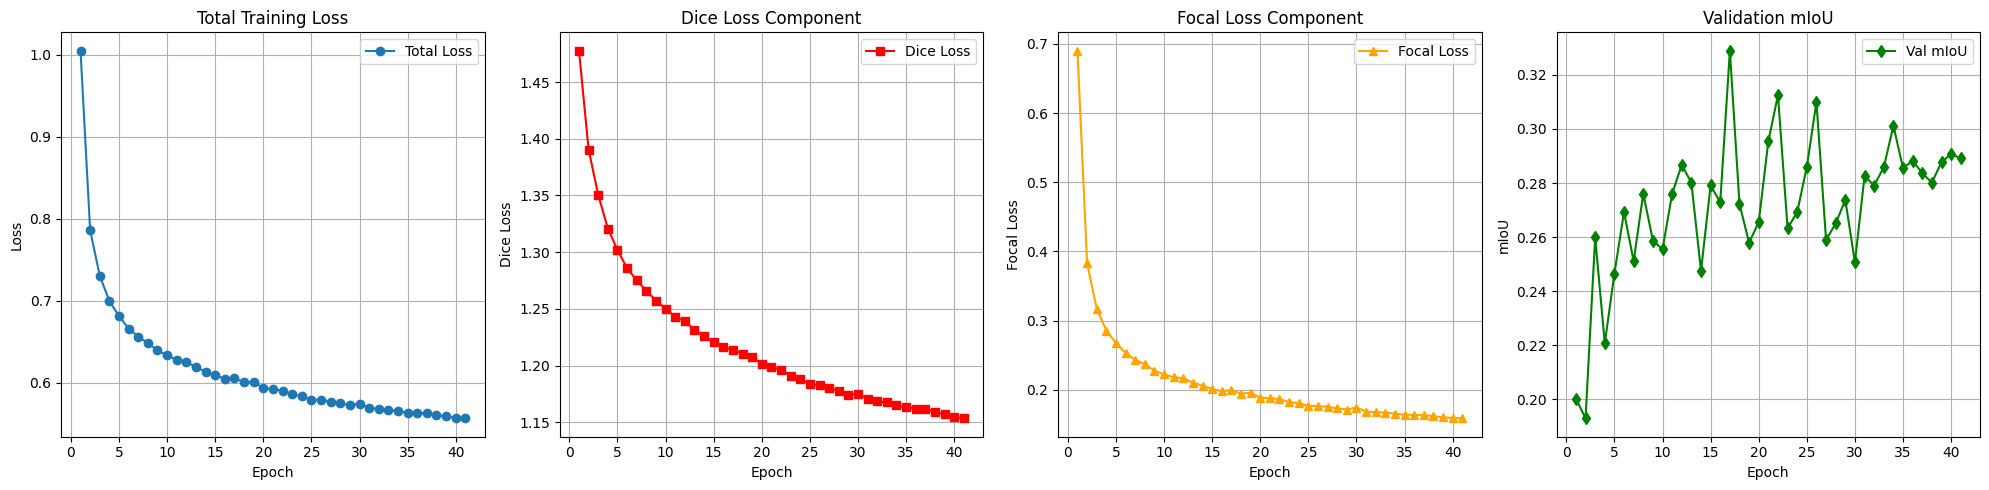

Epoch 42/50
  Total Loss: 0.5547
  Dice Loss:  1.1513
  Focal Loss: 0.1571


Per-class IoU:
  Road            : 0.6468
  Sidewalk        : 0.2878
  Building        : 0.7384
  Wall            : 0.1826
  Fence           : 0.1964
  Pole            : 0.2254
  Traffic light   : 0.2849
  Traffic sign    : 0.1142
  Vegetation      : 0.7819
  Terrain         : 0.2003
  Sky             : 0.6614
  Person          : 0.4912
  Rider           : 0.1299
  Car             : 0.3737
  Truck           : 0.1518
  Bus             : 0.2000
  Train           : 0.0431
  Motorcycle      : 0.0995
  Bicycle         : 0.0886
  Mean IoU: 0.3104


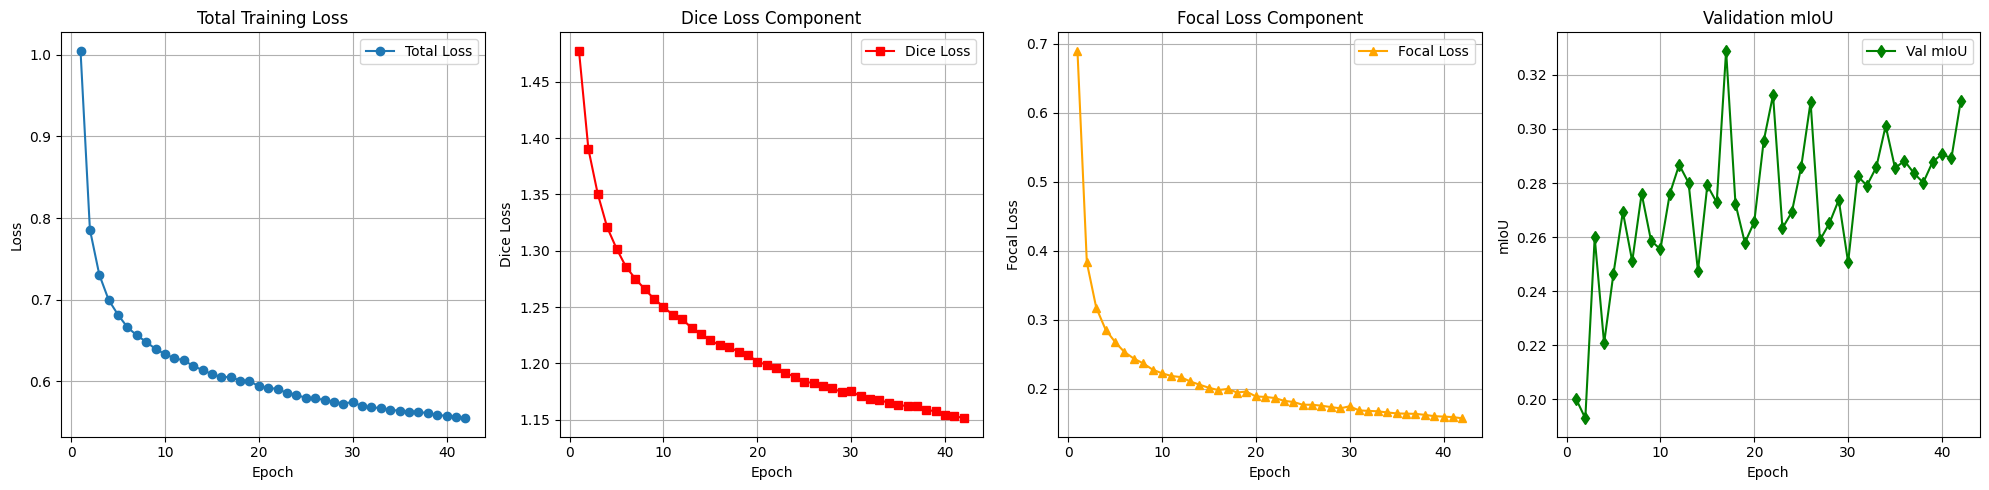

Epoch 43/50
  Total Loss: 0.5542
  Dice Loss:  1.1508
  Focal Loss: 0.1565


Per-class IoU:
  Road            : 0.6448
  Sidewalk        : 0.3715
  Building        : 0.7200
  Wall            : 0.1542
  Fence           : 0.1777
  Pole            : 0.2403
  Traffic light   : 0.2619
  Traffic sign    : 0.0996
  Vegetation      : 0.7686
  Terrain         : 0.1833
  Sky             : 0.6970
  Person          : 0.4287
  Rider           : 0.1081
  Car             : 0.3671
  Truck           : 0.1313
  Bus             : 0.1148
  Train           : 0.0145
  Motorcycle      : 0.0959
  Bicycle         : 0.1385
  Mean IoU: 0.3009


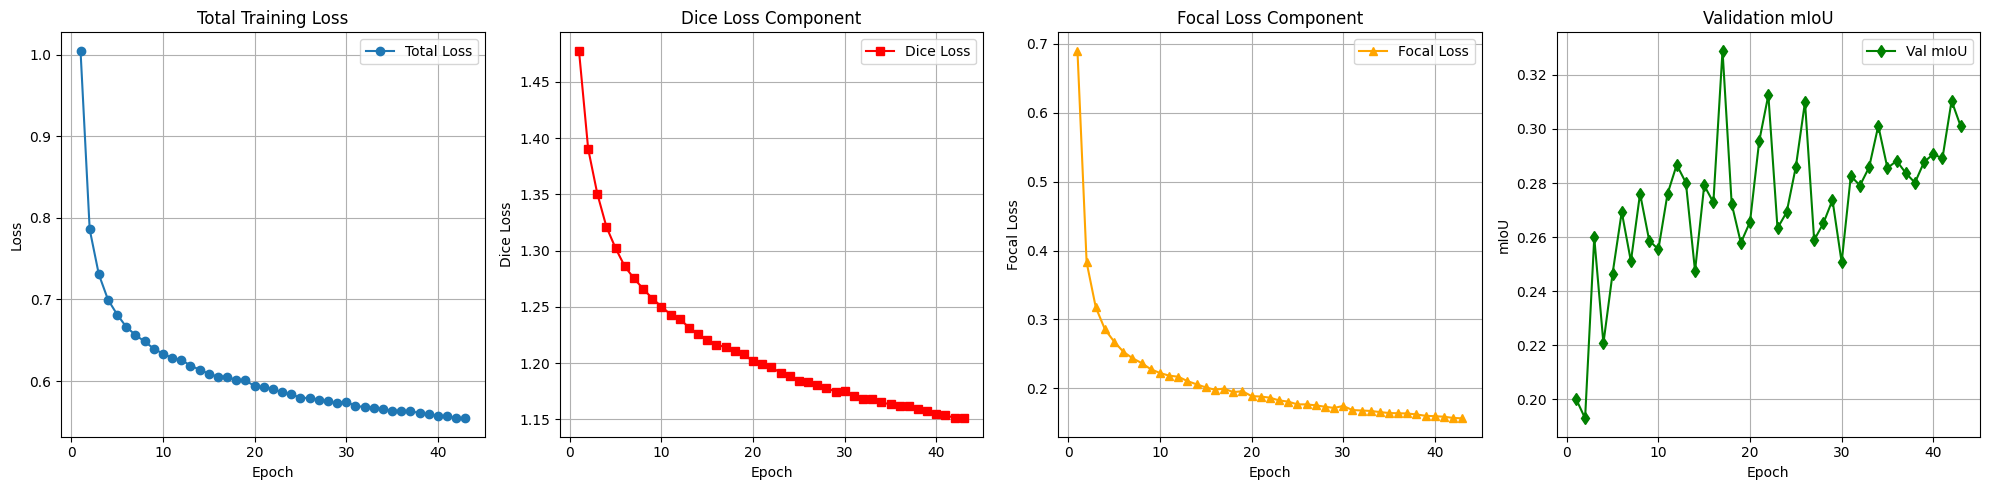

Epoch 44/50
  Total Loss: 0.5520
  Dice Loss:  1.1480
  Focal Loss: 0.1547


Per-class IoU:
  Road            : 0.6061
  Sidewalk        : 0.2946
  Building        : 0.7356
  Wall            : 0.1667
  Fence           : 0.1945
  Pole            : 0.2538
  Traffic light   : 0.2908
  Traffic sign    : 0.1658
  Vegetation      : 0.7444
  Terrain         : 0.0901
  Sky             : 0.6704
  Person          : 0.4943
  Rider           : 0.1269
  Car             : 0.3784
  Truck           : 0.1132
  Bus             : 0.1257
  Train           : 0.0281
  Motorcycle      : 0.0991
  Bicycle         : 0.1063
  Mean IoU: 0.2992


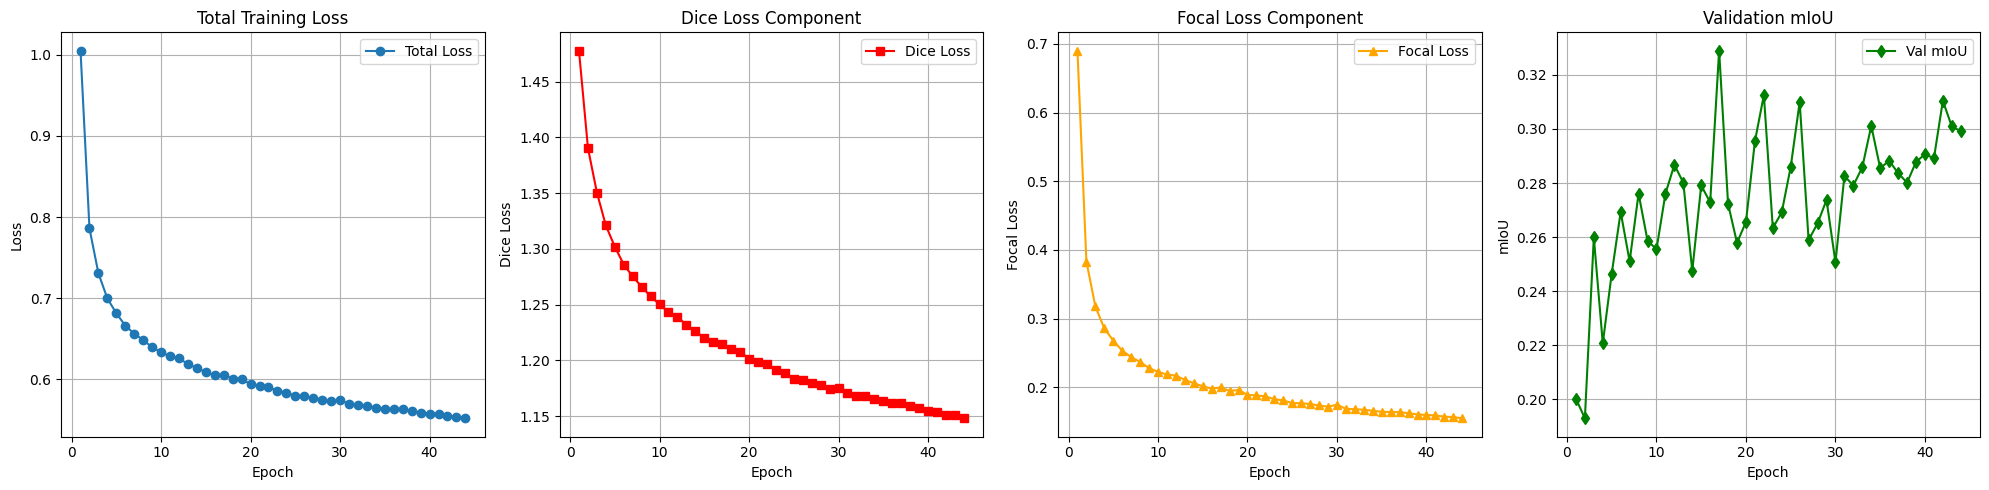

Epoch 45/50
  Total Loss: 0.5529
  Dice Loss:  1.1478
  Focal Loss: 0.1563


Per-class IoU:
  Road            : 0.5491
  Sidewalk        : 0.3549
  Building        : 0.7365
  Wall            : 0.1628
  Fence           : 0.1775
  Pole            : 0.2525
  Traffic light   : 0.2914
  Traffic sign    : 0.1397
  Vegetation      : 0.7505
  Terrain         : 0.1254
  Sky             : 0.7000
  Person          : 0.4763
  Rider           : 0.1182
  Car             : 0.3023
  Truck           : 0.1354
  Bus             : 0.1565
  Train           : 0.0420
  Motorcycle      : 0.1011
  Bicycle         : 0.1089
  Mean IoU: 0.2990
  Checkpoint saved at /content/drive/MyDrive/semantic segmentation/bisenet+loss_functions/dice+focal/checkpoint.pth


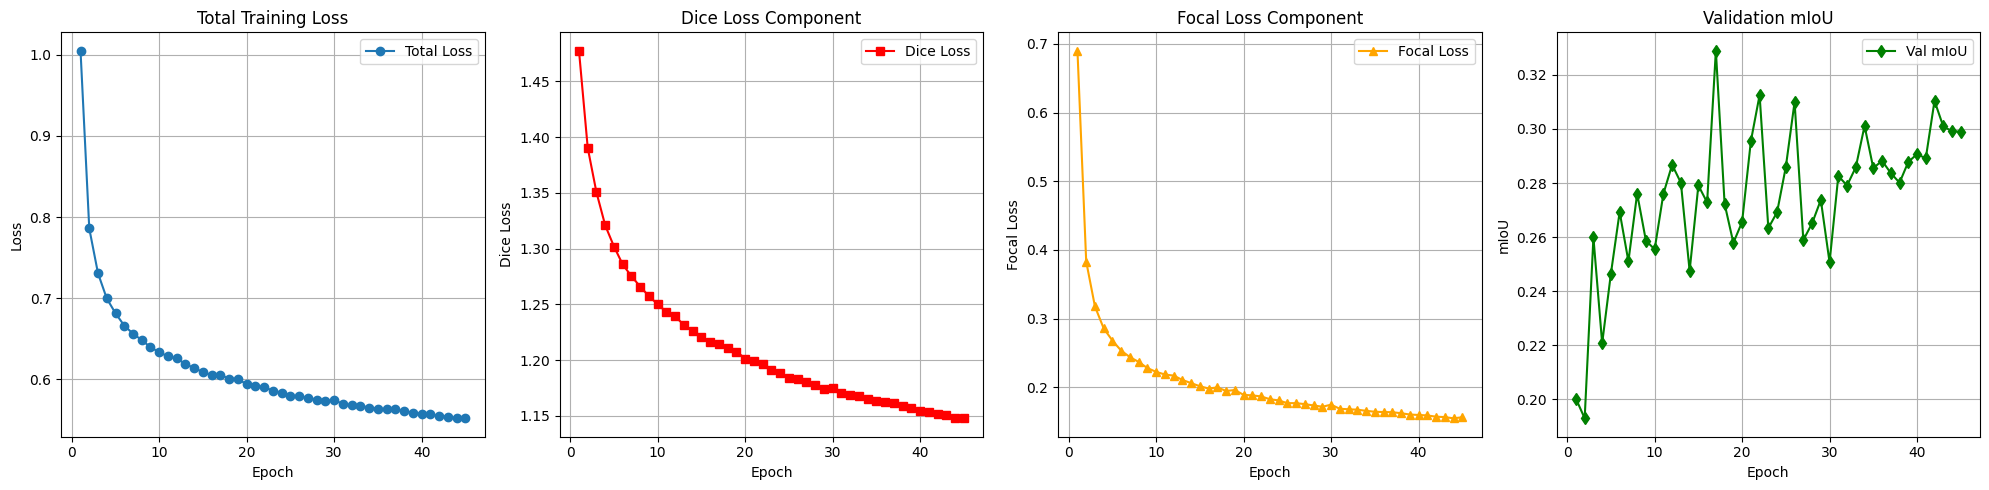

Epoch 46/50
  Total Loss: 0.5508
  Dice Loss:  1.1454
  Focal Loss: 0.1545


Per-class IoU:
  Road            : 0.4725
  Sidewalk        : 0.2455
  Building        : 0.7322
  Wall            : 0.1529
  Fence           : 0.1812
  Pole            : 0.2479
  Traffic light   : 0.2719
  Traffic sign    : 0.1479
  Vegetation      : 0.7408
  Terrain         : 0.0609
  Sky             : 0.6413
  Person          : 0.4855
  Rider           : 0.1503
  Car             : 0.3293
  Truck           : 0.1505
  Bus             : 0.1469
  Train           : 0.0314
  Motorcycle      : 0.0909
  Bicycle         : 0.0918
  Mean IoU: 0.2827


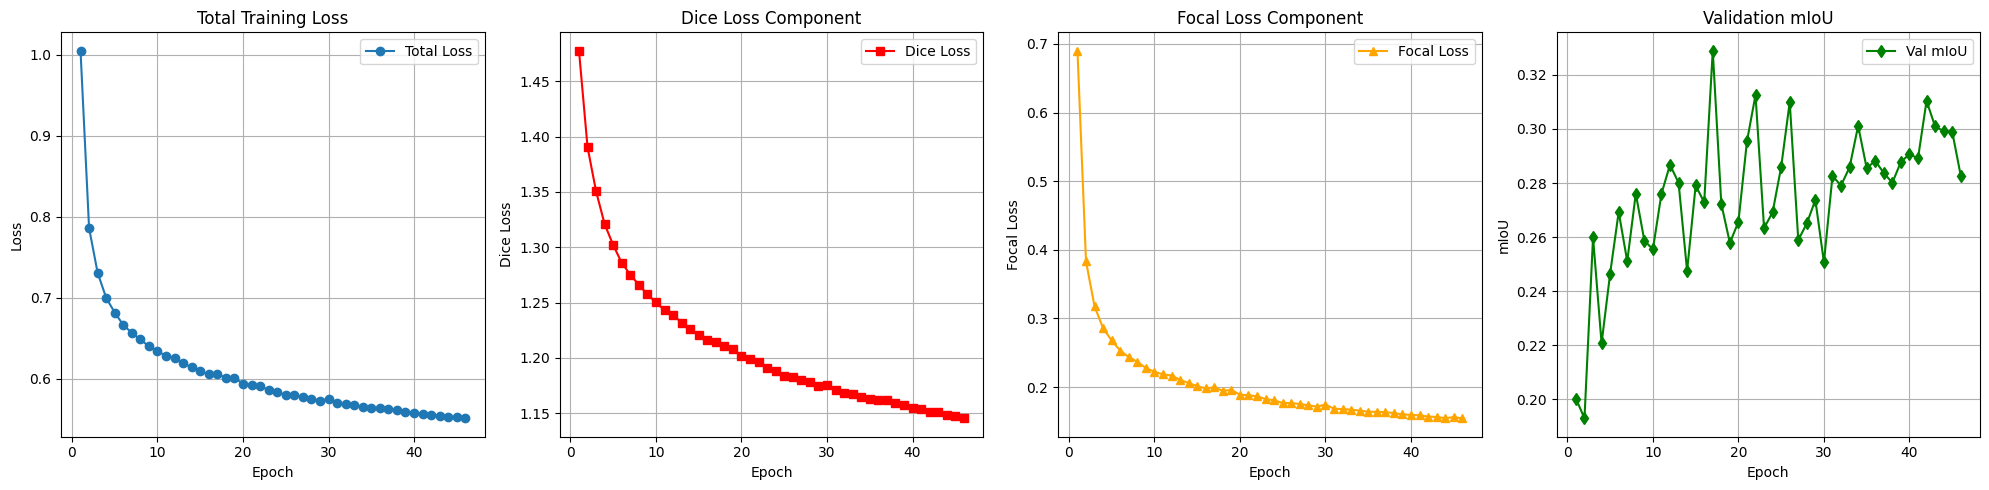

Epoch 47/50
  Total Loss: 0.5506
  Dice Loss:  1.1456
  Focal Loss: 0.1540


Per-class IoU:
  Road            : 0.5885
  Sidewalk        : 0.2979
  Building        : 0.7304
  Wall            : 0.1645
  Fence           : 0.1845
  Pole            : 0.2584
  Traffic light   : 0.2919
  Traffic sign    : 0.1282
  Vegetation      : 0.7643
  Terrain         : 0.1745
  Sky             : 0.6415
  Person          : 0.4862
  Rider           : 0.1549
  Car             : 0.3234
  Truck           : 0.1043
  Bus             : 0.1318
  Train           : 0.0315
  Motorcycle      : 0.0937
  Bicycle         : 0.1129
  Mean IoU: 0.2981


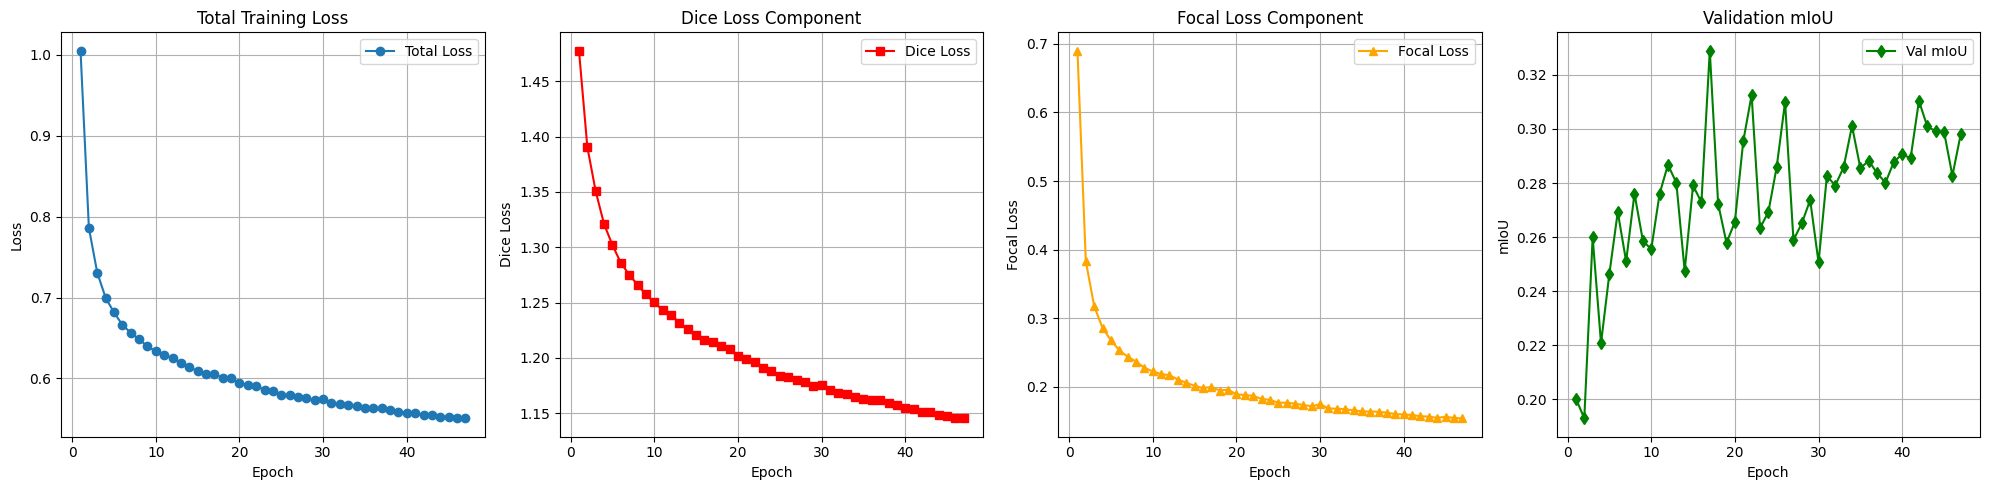

Epoch 48/50
  Total Loss: 0.5498
  Dice Loss:  1.1450
  Focal Loss: 0.1530


Per-class IoU:
  Road            : 0.5532
  Sidewalk        : 0.2942
  Building        : 0.7294
  Wall            : 0.1614
  Fence           : 0.1935
  Pole            : 0.2636
  Traffic light   : 0.2842
  Traffic sign    : 0.1384
  Vegetation      : 0.7543
  Terrain         : 0.1335
  Sky             : 0.6617
  Person          : 0.4792
  Rider           : 0.1456
  Car             : 0.3036
  Truck           : 0.1158
  Bus             : 0.1190
  Train           : 0.0336
  Motorcycle      : 0.0977
  Bicycle         : 0.1336
  Mean IoU: 0.2945


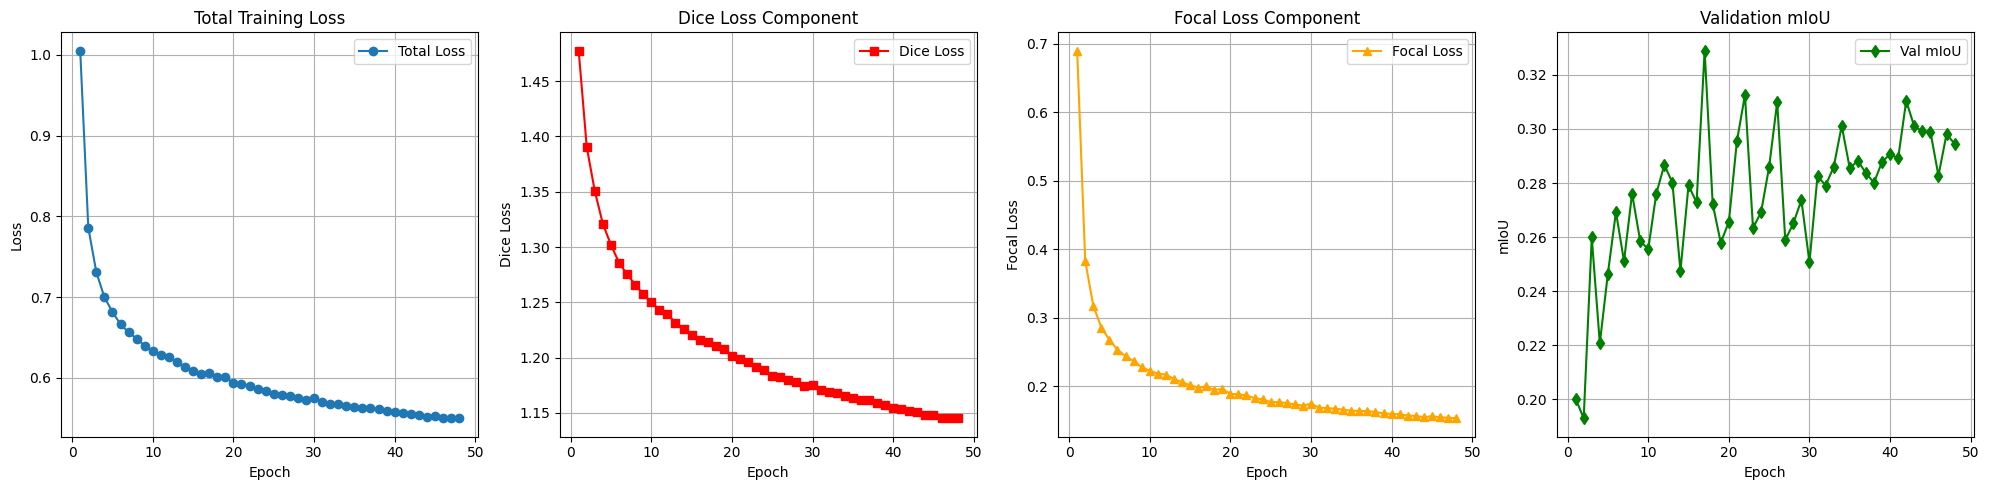

Epoch 49/50
  Total Loss: 0.5482
  Dice Loss:  1.1429
  Focal Loss: 0.1516


Per-class IoU:
  Road            : 0.5381
  Sidewalk        : 0.2969
  Building        : 0.7379
  Wall            : 0.1562
  Fence           : 0.1826
  Pole            : 0.2554
  Traffic light   : 0.2860
  Traffic sign    : 0.1285
  Vegetation      : 0.7686
  Terrain         : 0.1227
  Sky             : 0.6641
  Person          : 0.4749
  Rider           : 0.1455
  Car             : 0.2991
  Truck           : 0.1441
  Bus             : 0.1306
  Train           : 0.0304
  Motorcycle      : 0.0933
  Bicycle         : 0.1295
  Mean IoU: 0.2939


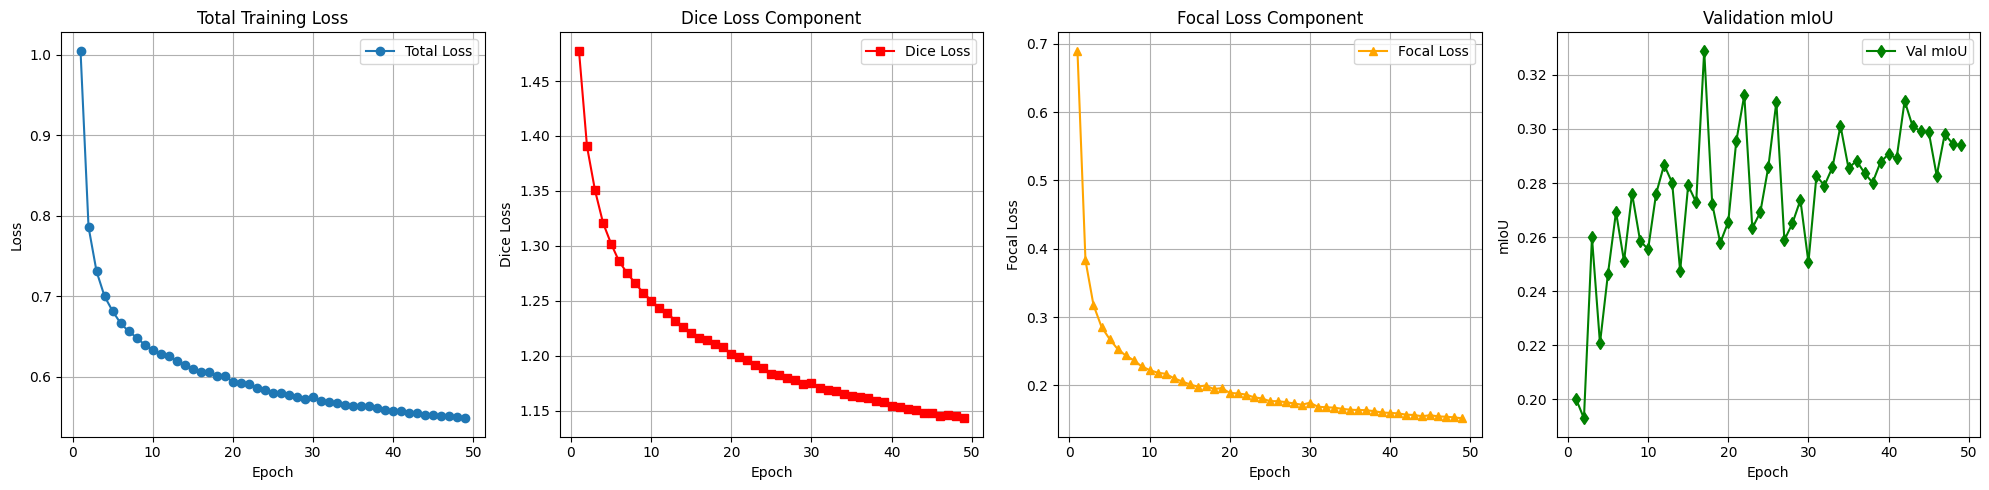

Epoch 50/50
  Total Loss: 0.5476
  Dice Loss:  1.1425
  Focal Loss: 0.1509


Per-class IoU:
  Road            : 0.5593
  Sidewalk        : 0.3159
  Building        : 0.7431
  Wall            : 0.1734
  Fence           : 0.1884
  Pole            : 0.2609
  Traffic light   : 0.2910
  Traffic sign    : 0.1262
  Vegetation      : 0.7698
  Terrain         : 0.1622
  Sky             : 0.6726
  Person          : 0.4845
  Rider           : 0.1497
  Car             : 0.2973
  Truck           : 0.1379
  Bus             : 0.1527
  Train           : 0.0398
  Motorcycle      : 0.0921
  Bicycle         : 0.1224
  Mean IoU: 0.3021
  Checkpoint saved at /content/drive/MyDrive/semantic segmentation/bisenet+loss_functions/dice+focal/checkpoint.pth


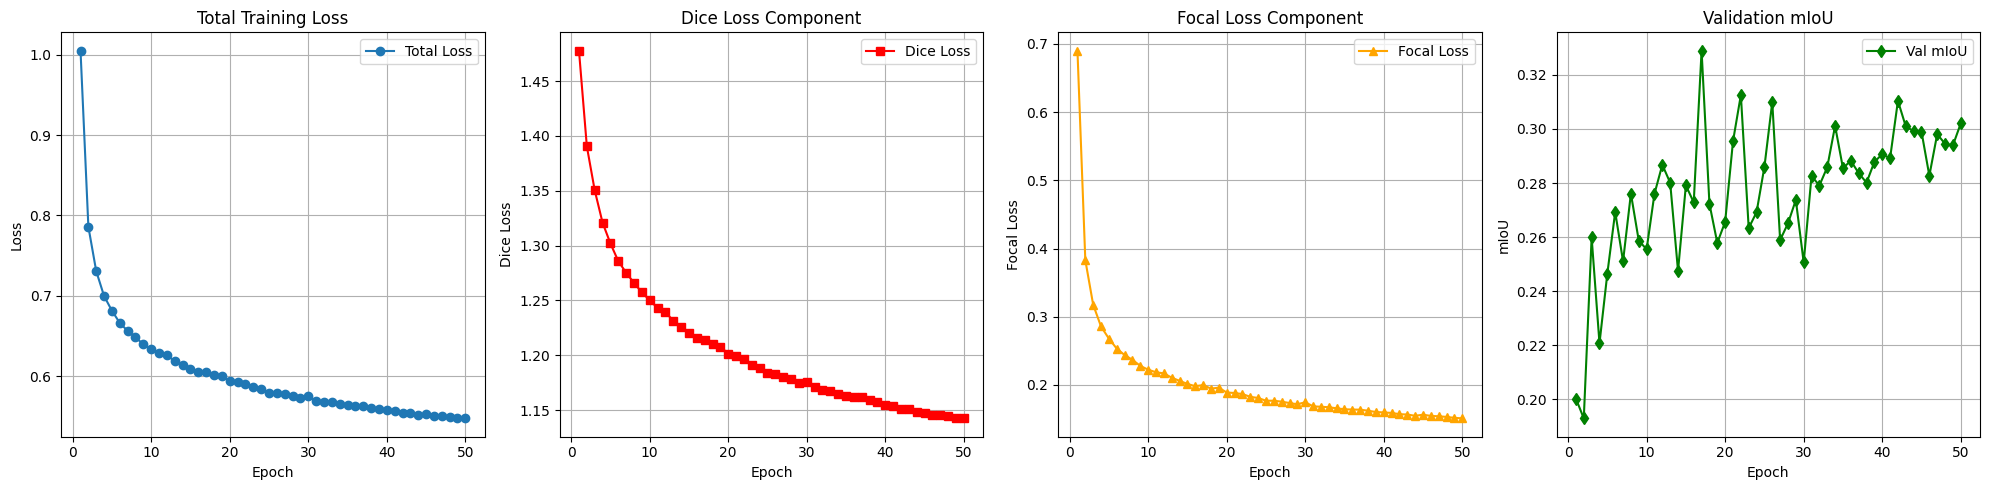

Training completed!


In [ ]:
import torch
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import torchvision.transforms.functional as TF


learning_rate = 1e-2
epochs = 50

model = BiSeNet(num_classes=19, context_path='resnet18')
optimizer = optim.SGD(model.optim_parameters(learning_rate), momentum=0.9, weight_decay=5e-4)

# combined loss function
criterion = CombinedLoss(
    dice_weight=0.4,
    focal_weight=0.6,
    focal_alpha=1.0,
    focal_gamma=2.0,
    ignore_index=255
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

scaler = GradScaler()
max_iter = len(train_dataloader) * epochs

start_epoch = 0
iteration = 0

# logs
# log_csv_path = log_path
log_df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_dice', 'train_focal', 'val_miou'])
train_losses = []
train_dice_losses = []
train_focal_losses = []
val_mious = []

# training

for epoch in range(start_epoch, epochs):


    model.train()
    running_loss = 0.0
    running_dice = 0.0
    running_focal = 0.0

    train_loader_tqdm = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

    for images, masks in train_loader_tqdm:
        images = images.to(device)
        masks = masks.to(device, dtype=torch.long)

        optimizer.zero_grad()

        with autocast():
            outputs, aux1, aux2 = model(images)

            # general loss
            combined_main, dice_main, focal_main = criterion(outputs, masks)
            combined_aux1, dice_aux1, focal_aux1 = criterion(aux1, masks)
            combined_aux2, dice_aux2, focal_aux2 = criterion(aux2, masks)

            # final loss
            total_loss = combined_main + 0.4 * combined_aux1 + 0.4 * combined_aux2
            total_dice = dice_main + 0.4 * dice_aux1 + 0.4 * dice_aux2
            total_focal = focal_main + 0.4 * focal_aux1 + 0.4 * focal_aux2

        scaler.scale(total_loss).backward()


        poly_lr_scheduler(optimizer, learning_rate, iteration, max_iter=max_iter)
        iteration += 1

        scaler.step(optimizer)
        scaler.update()

        # metrics
        running_loss += total_loss.item()
        running_dice += total_dice.item()
        running_focal += total_focal.item()

        train_loader_tqdm.set_postfix(
            loss=f"{total_loss.item():.4f}",
            dice=f"{total_dice.item():.4f}",
            focal=f"{total_focal.item():.4f}"
        )

    # mean per epoch
    epoch_loss = running_loss / len(train_dataloader)
    epoch_dice = running_dice / len(train_dataloader)
    epoch_focal = running_focal / len(train_dataloader)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Total Loss: {epoch_loss:.4f}")
    print(f"  Dice Loss:  {epoch_dice:.4f}")
    print(f"  Focal Loss: {epoch_focal:.4f}")

    # Validation
    model.eval()
    hist = np.zeros((19, 19))

    val_loader_tqdm = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)

    with torch.no_grad():
        for images, masks in val_loader_tqdm:
            images = images.to(device)
            masks = masks.to(device, dtype=torch.long)

            with autocast():
                outputs = model(images)

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            targets = masks.cpu().numpy()
            targets[targets == 255] = -1

            for lt, lp in zip(targets, preds):
                hist += fast_hist(lt.flatten(), lp.flatten(), 19)


    ious = per_class_iou(hist)
    print("Per-class IoU:")
    for idx, (cls_name, iou) in enumerate(zip(CITYSCAPES_CLASSES, ious)):
        print(f"  {cls_name:16s}: {iou:.4f}")

    epoch_miou = np.nanmean(ious)
    print(f"  Mean IoU: {epoch_miou:.4f}")

    # checkpoints
    if (epoch + 1) % 5 == 0:
        # checkpoint_path = chkpt
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'iteration': iteration,
            'scaler_state_dict': scaler.state_dict()
        }, checkpoint_path)
        print(f"  Checkpoint saved at {checkpoint_path}")

    #
    train_losses.append(epoch_loss)
    train_dice_losses.append(epoch_dice)
    train_focal_losses.append(epoch_focal)
    val_mious.append(epoch_miou)

    plt.figure(figsize=(20, 5))

    # Total Loss
    plt.subplot(1, 4, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Total Training Loss')
    plt.grid(True)
    plt.legend()

    # Dice Loss
    plt.subplot(1, 4, 2)
    plt.plot(range(1, len(train_dice_losses) + 1), train_dice_losses, marker='s', color='red', label='Dice Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Loss')
    plt.title('Dice Loss Component')
    plt.grid(True)
    plt.legend()

    # Focal Loss
    plt.subplot(1, 4, 3)
    plt.plot(range(1, len(train_focal_losses) + 1), train_focal_losses, marker='^', color='orange', label='Focal Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Focal Loss')
    plt.title('Focal Loss Component')
    plt.grid(True)
    plt.legend()

    # Validation mIoU
    plt.subplot(1, 4, 4)
    plt.plot(range(1, len(val_mious) + 1), val_mious, marker='d', color='green', label='Val mIoU')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.title('Validation mIoU')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()

    # save graphs
    if (epoch + 1) == epochs:
        plt.savefig(lossmiou)

    plt.show()
    plt.close()

    # save csv
    log_df.loc[len(log_df)] = {
        'epoch': epoch + 1,
        'train_loss': epoch_loss,
        'train_dice': epoch_dice,
        'train_focal': epoch_focal,
        'val_miou': epoch_miou
    }

    log_df.to_csv(log_csv_path, index=False)

print("Training completed!")